# Predicting Football Matches

##### This is the 'code file' for my 'Predicting Football matches' Data Science Project. For readability, I have divide the file into the following sections:

#### Part 1: Cleaning and combining data for analysis

This section of the code cleans and trasnforms the data from the raw CSV files into something which can be used for analysis. 

#### Part 2: Creating the 'strength' metrics and initial analysis

This section of the code transforms the data to track team's performances over time. An inital assesment is made of the predictive power of the metrics, to asses which ones are the most appropraite to move forward with. 

#### Part 3: Analysing the expected Goals data

This sections takes a closer look at xG to determine if it is indeed a useful metric to use for predicting games. 

#### Part 4: Further Analysis and Machine Leanring

This section uses linear regression to determine the coefficients and compares the results to the 'simple' version of the model. An assesment is made of the validity of the predicitons. The KNN model is used to predict the absolute outcome of a game.Finally, the siutability of the poisson distribution is assesed.

#### Part 5: Using the Poisson distribution to predict outcomes

This section creates odds for each version of the model and uses functions to compare them to the odds made by the bookmakers, selecting the most 'profitbale' bet for each one. A simulation is created to track the outcomes over time. Key information about the models is captured, such as how many bets were recommened, and the expected value. 

#### Part 6: Investigating the profitable metric

This section investigates the predictions of the most profitable model, to understand how it generated a profit. 

#### Advice for running the code: 

Please note that this code references the raw csv files by their specifc file name. For the code to run without errors, the files will need to be saved locally or uploaded into colab. They name of file must also be exactly the same. When using the Anaconda distribution package, no pip installs are required, however, this may be required if using a different platform to run the code. 

# PART 1 : CLEANING AND COMBINING DATA

# 1.1: Initial data cleaning

## - Dropping unused columns
## - Combining the data so that each row contains the data for the home and away team
## - Adding counters to help track performace over time

In [1]:
#import libraries
import pandas as pd
import csv
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

In [2]:
#read the csv and drop unused coulmns 
df=pd.read_csv('understat_per_game.csv')
df.drop(['ppda_att','ppda_def','ppda_coef','oppda_coef','oppda_att','oppda_def','pts','xG_diff','xGA_diff','npxGD','wins','draws','loses','xpts','npxG','npxGA','deep','deep_allowed'],axis = 1, inplace = True)
df.rename(columns = {'scored':'goals_scored', 'missed':'goals_conceded'},inplace = True)

In [3]:
#simplify 'result' column

#create a function to combine the 'h_a' and 'result' columns
def combine_result(row):
    if row['h_a'] == 'h' and row['result'] == 'w':
        val ='homewin'
    elif row['h_a'] == 'a' and row['result'] == 'w':
        val ='awaywin' 
    elif row['h_a'] == 'h' and row['result'] == 'l':
        val ='awaywin'
    elif row['h_a'] == 'a' and row['result'] == 'l':
        val ='homewin'
    else:
        val = 'draw'
        
    return val

#update 'result' column using the function above
df['result'] = df.apply(combine_result, axis=1)



For our analysis, we need to know the relevant values for both the home team and the away team for each game. As you can see, the data does not include this. To tackle this, I have created the following functions, which create a new column based on if the team was home or away.

In [4]:
#create a function for a column named 'home_team'
def adjust_home_team(row):
    if row['h_a'] =='h':
        val = row['team']
    else:
        val = 'None'
    return val


#create an identical function for 'away_team'
def adjust_away_team(row):
    if row['h_a'] =='a':
        val = row['team']
    else:
        val = 'None'
    return val

#create new columns based on function above        
df['home_team'] = df.apply(adjust_home_team, axis=1)
df['away_team'] = df.apply(adjust_away_team, axis=1)

#drop the 'team' column
df.drop(['team'],axis = 1, inplace = True)

#rename to void confusion in column names
df.rename(columns = {'xG' : 'xGFor','xGA':'xGAgainst'}, inplace = True)

In [5]:
#create a function for a column named 'adjust_xG' - for the 'home' teams
def adjust_xG(row):
    if row['away_team'] =='None':
        val = row['xGFor']
    elif row['home_team'] =='None':
        val = row['xGAgainst']
    else:
        val = 'None'
    return val

df['home_expected_gaols_for'] = df.apply(adjust_xG, axis=1)

#create a function for a column named 'adjust_xG2' for the 'away' games 
def adjust_xG2(row):
    if row['home_team'] =='None':
        val = row['xGFor']
    elif row['away_team'] =='None':
        val = row['xGAgainst']
    else:
        val = 'None'
    return val

#create new column using the function above
df['home_expected_gaols_against'] = df.apply(adjust_xG2, axis=1)

#drop now-reedundant columns
df.drop(['xGFor','xGAgainst'],axis = 1, inplace = True)

#rename new columns
df.rename(columns = {'home_expected_gaols_for':'xGH', 'home_expected_gaols_against':'xGA'},inplace = True)

In [6]:
def adjust_goals1(row):
    if row['away_team'] =='None':
        val = row['goals_scored']
    elif row['home_team'] =='None':
        val = row['goals_conceded']
    else:
        val = 'None'
    return val


def adjust_goals2(row):
    if row['home_team'] =='None':
        val = row['goals_scored']
    elif row['away_team'] =='None':
        val = row['goals_conceded']
    else:
        val = 'None'
    return val

df['home_goals'] = df.apply(adjust_goals1, axis=1)
df['away_goals'] = df.apply(adjust_goals2, axis=1)

#drop now-redundant columns

df.drop(['goals_scored','goals_conceded'],axis = 1, inplace = True)

In [7]:
def adjust_xpts_diff1(row):
    if row['away_team'] =='None':
        val = row['xpts_diff']
    else:
        val = None
    return val

df['home_xpts_diff'] = df.apply(adjust_xpts_diff1, axis=1)

def adjust_xpts_diff2(row):
    if row['home_team'] =='None':
        val = row['xpts_diff']
    else:
        val = None
    return val

df['away_xpts_diff'] = df.apply(adjust_xpts_diff2, axis=1)
df.drop(['xpts_diff'],inplace = True , axis = 1)

In [8]:
#we no longer need the h_a column, so we can drop it 
df.drop(['h_a'],inplace = True , axis = 1)

In [9]:
#finally, there is an inconsistency in the data which must be corrected: The team 'Parma' appears twice, once as 'Parma' and later as 'Parma Calcio 1913'
# the function below corrects for this. 

def adjust_parma_home(row):
    if row['home_team'] == 'Parma':
        val = 'Parma Calcio 1913'
    else:
        val = row['home_team']
    return val

def adjust_parma_away(row):
    if row['away_team'] == 'Parma':
        val = 'Parma Calcio 1913'
    else:
        val = row['away_team']
    return val

df['home_team'] = df.apply(adjust_parma_home, axis=1)
df['away_team'] = df.apply(adjust_parma_away, axis=1)

Finally, we need to 'collapse' the dataframme so that the home and away results are on the same row. To do this, I will create a seperate column for the 'home' teams, to allow them to be removed from the main dataframe. I will then create a unqiue index for each game, and merge it back in. 

In [10]:
#create a dataframe for the home team only
home_df = df.drop(['away_team','xGA','home_goals','away_goals','away_xpts_diff'],axis=1)

#removes the away teams
home_df = home_df[home_df.home_team != 'None']

#convet to strings to allow creation of unique index
home_df['year']= home_df['year'].astype(str)
home_df['xGH']= home_df['xGH'].astype(str)

In [11]:
#create unique index
home_df['join'] = home_df['league'] + '_'+home_df['year']+'_'+home_df['result'] +'_'+ home_df['date']+ '_' + home_df['xGH']
home_df.drop(['league','year','result','date','xGH'],inplace= True, axis = 1)
home_df.set_index('join',inplace=True)

In [12]:
#drop the columns to be merged from the main df
df.drop(['home_team','home_xpts_diff'],axis=1,inplace = True)

#drop the home teams from the main df, as we will be merging them back in 
df = df[df.away_team != 'None']


In [13]:
#convert to strings to create identical index to the home_df
df['year']= df['year'].astype(str)
df['xGH']= df['xGH'].astype(str)

In [14]:
#create identical index
df['join'] = df['league'] + '_'+df['year']+'_'+df['result'] +'_'+ df['date']+ '_' + df['xGH']
df.set_index('join',inplace=True)

In [15]:
#merge the dataframes
df = df.merge(home_df, on = 'join')

In [16]:
#once complete, reset the index and drop the unique indexes - we no longer need them
df.reset_index(inplace = True)
df.drop(['join'],axis = 1, inplace = True)
df['xGH']= df['xGH'].astype(float)

In [17]:
#re-order dataframe for easy readability
df = df[['year', 'league','result', 'date', 'home_team', 'away_team','xGH','xGA','home_goals','away_goals','home_xpts_diff','away_xpts_diff']]


We also need to create counters, as we will be tracking the metrics over time. We need to know , for each game, which game in that season it was. 

In [18]:
# sort values by date to make sure df is in the correct order
df = df.sort_values(by=['date'])

#we need to keep teams distinct between seasons, so create a 'teamyear' index
df['home_team_year'] = df['home_team'] +'_'+ df['year']
df['away_team_year'] = df['away_team'] +'_'+ df['year']



In [19]:
#adds the counter using the teamyear index. This creates a counter for the season
df['home_game_counter'] = df.groupby('home_team_year').cumcount().add(1)
df['away_game_counter'] = df.groupby('away_team_year').cumcount().add(1)

#repeat the process using team as the only index, this will be the count for the entire dataset
df['home_game_counter_all'] = df.groupby('home_team').cumcount().add(1)
df['away_game_counter_all'] = df.groupby('away_team').cumcount().add(1)

#once drop them once they are no longer being used:
df.drop(['home_team_year','away_team_year'], axis = 1, inplace = True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12290 entries, 8575 to 12121
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   12290 non-null  object 
 1   league                 12290 non-null  object 
 2   result                 12290 non-null  object 
 3   date                   12290 non-null  object 
 4   home_team              12290 non-null  object 
 5   away_team              12290 non-null  object 
 6   xGH                    12290 non-null  float64
 7   xGA                    12290 non-null  float64
 8   home_goals             12290 non-null  int64  
 9   away_goals             12290 non-null  int64  
 10  home_xpts_diff         12290 non-null  float64
 11  away_xpts_diff         12290 non-null  float64
 12  home_game_counter      12290 non-null  int64  
 13  away_game_counter      12290 non-null  int64  
 14  home_game_counter_all  12290 non-null  int64  
 15 

# 1.2: Adding odds to the df

## - Bringing the data together from the different CSVs and combining
## - Assessing which columns to use for analysis
## - Dropping unused columns
## - Transforming the data to allow join into main dataframe
## - Merging the data 

In [21]:
#create a dataframe for each csv
odds_df1=pd.read_csv('La_liga_2014.csv')
odds_df2=pd.read_csv('La_liga_2015.csv')
odds_df3=pd.read_csv('La_liga_2016.csv')
odds_df4=pd.read_csv('La_liga_2017.csv')
odds_df5=pd.read_csv('La_liga_2018.csv')
odds_df6=pd.read_csv('La_liga_2019.csv')
odds_df7=pd.read_csv('Serie_A_2014.csv')
odds_df8=pd.read_csv('Serie_A_2015.csv')
odds_df9=pd.read_csv('Serie_A_2016.csv')
odds_df10=pd.read_csv('Serie_A_2017.csv')
odds_df11=pd.read_csv('Serie_A_2018.csv')
odds_df12=pd.read_csv('Serie_A_2019.csv')
odds_df13=pd.read_csv('Bundesliga_2014.csv')
odds_df14=pd.read_csv('Bundesliga_2015.csv')
odds_df15=pd.read_csv('Bundesliga_2016.csv')
odds_df16=pd.read_csv('Bundesliga_2017.csv')
odds_df17=pd.read_csv('Bundesliga_2018.csv')
odds_df18=pd.read_csv('Bundesliga_2019.csv')
odds_df19=pd.read_csv('EPL_2014.csv')
odds_df20=pd.read_csv('EPL_2015.csv')
odds_df21=pd.read_csv('EPL_2016.csv')
odds_df22=pd.read_csv('EPL_2017.csv')
odds_df23=pd.read_csv('EPL_2018.csv')
odds_df24=pd.read_csv('EPL_2019.csv')
odds_df25=pd.read_csv('Ligue1_2014.csv')
odds_df26=pd.read_csv('Ligue1_2015.csv')
odds_df27=pd.read_csv('Ligue1_2016.csv')
odds_df28=pd.read_csv('Ligue1_2017.csv')
odds_df29=pd.read_csv('Ligue1_2018.csv')
odds_df30=pd.read_csv('Ligue1_2019.csv')

In [22]:
#combine the seperate csv files into a single df 
odds_df = pd.concat([odds_df1, odds_df2, odds_df3,odds_df4,odds_df5,odds_df6,odds_df7,odds_df8,odds_df9,odds_df10,odds_df11,odds_df12,odds_df13,odds_df14,odds_df15,odds_df16,odds_df17,odds_df18,odds_df19,odds_df20,odds_df21,odds_df22,odds_df23,odds_df24,odds_df25,odds_df26,odds_df27,odds_df28,odds_df29,odds_df30],ignore_index=True)


In [23]:
#drop unused columns
odds_df.drop(['FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA',
 'Bb1X2',
 'BbMxH',
 'BbAvH',
 'BbMxD',
 'BbAvD',
 'BbMxA',
 'BbAvA',
 'BbOU',
 'BbMx>2.5',
 'BbAv>2.5',
 'BbMx<2.5',
 'BbAv<2.5',
 'BbAH',
 'BbAHh',
 'BbMxAHH',
 'BbAvAHH',
 'BbMxAHA',
 'BbAvAHA',
 'PSCH',
 'PSCD',
 'PSCA',
 'Time',
 'MaxH',
 'MaxD',
 'MaxA',
 'P>2.5',
 'P<2.5',
 'Max>2.5',
 'Max<2.5',
 'AHh',
 'B365AHH',
 'B365AHA',
 'PAHH',
 'PAHA',
 'MaxAHH',
 'MaxAHA',
 'AvgAHH',
 'AvgAHA',
 'B365CH',
 'B365CD',
 'B365CA',
 'BWCH',
 'BWCD',
 'BWCA',
 'IWCH',
 'IWCD',
 'IWCA',
 'WHCH',
 'WHCD',
 'WHCA',
 'VCCH',
 'VCCD',
 'VCCA',
 'MaxCH',
 'MaxCD',
 'MaxCA',
 'B365C>2.5',
 'B365C<2.5',
 'PC>2.5',
 'PC<2.5',
 'MaxC>2.5',
 'MaxC<2.5',
 'AHCh',
 'B365CAHH',
 'B365CAHA',
 'PCAHH',
 'PCAHA',
 'MaxCAHH',
 'B365>2.5',
 'B365<2.5',
 'MaxCAHA',
 'AvgCAHH',
 'AvgCAHA',
 'Referee'],axis=1,inplace=True)


In [24]:
#Looking at the information below, it looks like the most complete dataset we have is from Bet365 (10854 non-null). Therefore, we will use this dataset. 
odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10859 entries, 0 to 10858
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Div       10855 non-null  object 
 1   Date      10855 non-null  object 
 2   HomeTeam  10855 non-null  object 
 3   AwayTeam  10855 non-null  object 
 4   B365H     10854 non-null  float64
 5   B365D     10854 non-null  float64
 6   B365A     10854 non-null  float64
 7   AvgH      1725 non-null   float64
 8   AvgD      1725 non-null   float64
 9   AvgA      1725 non-null   float64
 10  Avg>2.5   1725 non-null   float64
 11  Avg<2.5   1725 non-null   float64
 12  AvgCH     1725 non-null   float64
 13  AvgCD     1725 non-null   float64
 14  AvgCA     1725 non-null   float64
 15  AvgC>2.5  1725 non-null   float64
 16  AvgC<2.5  1725 non-null   float64
dtypes: float64(13), object(4)
memory usage: 1.4+ MB


In [25]:
odds_df.drop(['AvgH','AvgD','AvgA','Avg>2.5','AvgCH','AvgCD','AvgCA','AvgC>2.5','AvgC<2.5','Avg<2.5'],axis=1,inplace=True)

In [26]:
#rename columns to allow for joining into main df
odds_df.rename(columns = {'Div':'league',
                     'HomeTeam':'home_team',
                     'AwayTeam':'away_team',
                     'Date':'date',
                     'B365H':'home_odds',
                     'B365D':'draw_odds',
                     'B365A':'away_odds'},inplace = True)

In [27]:
#make sure the team names match (sometimes, teams have slightly different naming conventions)


#create a dicgtionary of the required replacements
replace_dict = {'Ajaccio GFCO':'GFC Ajaccio',
               'Ath Bilbao':'Athletic Club',
               'Ath Madrid':'Atletico Madrid',
               'Bastia':'SC Bastia',
               'Betis':'Real Betis',
               'Celta':'Celta Vigo',
               'Dortmund':'Borussia Dortmund',
               'Ein Frankfurt':'Eintracht Frankfurt',
               'Espanol':'Espanyol',
               'FC Koln':'FC Cologne',
               'Fortuna Dusseldorf':'Fortuna Duesseldorf',
               'Hamburg':'Hamburger SV',
               'Hannover':'Hannover 96',
               'Hertha':'Hertha Berlin',
               'Huesca':'SD Huesca',
               'La Coruna':'Deportivo La Coruna',
               'Leverkusen':'Bayer Leverkusen',
               "M'gladbach":"Borussia M.Gladbach",
               'Mainz':'Mainz 05',
               'Man City':'Manchester City',
               'Man United':'Manchester United',
               'Milan':'AC Milan',
               'Newcastle':'Newcastle United',
               'Nurnberg':'Nuernberg',
               'Paris SG':'Paris Saint Germain',
                'Parma':'Parma Calcio 1913',
               'QPR':'Queens Park Rangers',
               'RB Leipzig':'RasenBallsport Leipzig',
               'Sociedad':'Real Sociedad',
               'Sp Gijon':'Sporting Gijon',
               'Spal':'SPAL 2013',
               'St Etienne':'Saint-Etienne',
               'Stuttgart':'VfB Stuttgart',
               'Valladolid':'Real Valladolid',
               'Vallecano':'Rayo Vallecano',
                'West Brom':'West Bromwich Albion',
                'Wolves':'Wolverhampton Wanderers'}

odds_df["home_team"] = odds_df.home_team.replace(replace_dict)
odds_df["away_team"] = odds_df.away_team.replace(replace_dict)


In [28]:
#repeat process for league column

#create a disctionary as before
replace_dict2 = {'D1':'Bundesliga','F1':'Ligue_1','E0':'EPL','SP1':'La_liga','I1':'Serie_A',}
odds_df["league"] = odds_df.league.replace(replace_dict2)

Next, we need to convert the dates so that we can use comparison operations 

In [29]:
#convert data column to datetime , to allow assignment of 'year' value below
odds_df['date'] = pd.to_datetime(odds_df['date'],dayfirst=True)

In [30]:
odds_df['2014'] ='2015-07-01'
odds_df['2015'] ='2016-07-01'
odds_df['2016'] ='2017-07-01'
odds_df['2017'] ='2018-07-01'
odds_df['2018'] ='2019-07-01'
odds_df['2019'] ='2020-11-01'

odds_df['2014'] = odds_df['2014'].astype('datetime64[ns]')
odds_df['2015'] = odds_df['2015'].astype('datetime64[ns]')
odds_df['2016'] = odds_df['2016'].astype('datetime64[ns]')
odds_df['2017'] = odds_df['2017'].astype('datetime64[ns]')
odds_df['2018'] = odds_df['2018'].astype('datetime64[ns]')
odds_df['2019'] = odds_df['2019'].astype('datetime64[ns]')


def adjust_date(row):
    if row['date'] < row['2014']:
        val = '2014'
    elif row['date'] < row['2015']:
        val = '2015'
    elif row['date'] < row['2016']:
        val = '2016'
    elif row['date'] < row['2017']:
        val = '2017'
    elif row['date'] < row['2018']:
        val = '2018'
    elif row['date'] < row['2019']:
        val = '2019'
    else:
        val = 'NA'
    return val
        
odds_df['year'] = odds_df.apply(adjust_date, axis=1)

odds_df.drop(['2014','2015','2016','2017','2018','2019'], axis = 1, inplace = True)

CSV for the russian league is in a different format, so we will need to add it seperately. 

In [31]:
russ_odds_df = pd.read_csv('RUS.csv')
#drop redundant columns, in this case, we will drop 'date', as this df already has a 'season' column
russ_odds_df.drop(['Country','League','Date','Time','HG','AG','PH','PD','PA','MaxH','MaxD','MaxA','MaxH','Res'],axis = 1, inplace = True)

In [32]:
#adjust the season column to match the df

def adjust_season(row):
    if row['Season'] == '2012/2013':
        val = '2012'
    elif row['Season'] == '2013/2014':
        val = '2013'
    elif row['Season'] == '2014/2015':
        val = '2014'
    elif row['Season'] == '2015/2016':
        val = '2015'
    elif row['Season'] == '2016/2017':
        val = '2016'
    elif row['Season'] == '2017/2018':
        val = '2017'
    elif row['Season'] == '2018/2019':
        val = '2018'
    elif row['Season'] == '2019/2020':
        val = '2019'
    elif row['Season'] == '2020/2021':
        val = '2020'
    else:
        val = 'not_matched'
    return val

russ_odds_df['Season'] = russ_odds_df.apply(adjust_season, axis=1)

In [33]:
#drop the seasons which we are not using: 
values = ['2012','2013','2020']
russ_odds_df = russ_odds_df[russ_odds_df.Season.isin(values) == False]

In [34]:
replace_dict2 = {
    'Akhmat Grozny':'FK Akhmat',
    'Dynamo Moscow':'Dinamo Moscow',
    'FK Anzi Makhackala':'Anzhi Makhachkala',
    'FK Krylya Sovetov Samara': 'Krylya Sovetov Samara',
    'FK Rostov':'FC Rostov',
    'Krasnodar':'FC Krasnodar',
    'Kuban':'Kuban Krasnodar',
    'M. Saransk':'Mordovya',
    'Orenburg':'FC Orenburg',
    'SKA Khabarovsk':'SKA-Khabarovsk',
    'Sochi':'PFC Sochi',
    'T. Moscow':'Torpedo Moscow',
    'Tambov':'FC Tambov',
    'Tomsk':'Tom Tomsk',
    'Ufa':'FC Ufa',
    'Yenisey':'FC Yenisey Krasnoyarsk',
    'Zenit': 'Zenit St. Petersburg'
}

russ_odds_df["Home"] = russ_odds_df.Home.replace(replace_dict2)
russ_odds_df["Away"] = russ_odds_df.Away.replace(replace_dict2)


In [35]:
#rename columns to allow for joining into main df
russ_odds_df.rename(columns = {'Season':'year',
                     'Home':'home_team',
                     'Away':'away_team',
                     'AvgH':'home_odds',
                     'AvgD':'draw_odds',
                     'AvgA':'away_odds'},inplace = True)

In [36]:
#need to combine the two dataframes

#drop unused odds_df columns
odds_df.drop(['league','date'],inplace = True, axis = 1)

#re-order russ df to allow concat
russ_odds_df = russ_odds_df[['home_team','away_team','home_odds','draw_odds','away_odds','year']]

#concat the two dfs

odds_df = pd.concat([odds_df,russ_odds_df])

In [37]:
#need to create a unique index for both

#create a unique index of hometeam + awayteam + year
odds_df['home_away_year'] = odds_df['home_team'] + '_' + odds_df['away_team'] + '_' + odds_df['year']
odds_df.drop(['home_team','away_team','year'],axis = 1 , inplace = True)

#create a matching index in the main df
df['year'] = df['year'].astype(str)
df['home_away_year'] = df['home_team'] + '_' + df['away_team'] + '_' + df['year']

In [38]:
#merge the dataframes on this newly-created index
df = df.merge(odds_df, on = 'home_away_year', how = 'left')

# PART 2 : CREATING METRICS AND INITIAL ANALYSIS

# 2.1: Creating metrics 

## - Spiltting the dataframes into 4 , to allow tracking over time
## - Creating different metrics
## - Adding these metrics into the dataframe


In the cells below, I create seperate dataframes for the home excpected goals for, home expected goals against, away expected goals for and away expected goals against. This will allow me to track changes over time. 

In [39]:
#create a subset of the main dataframe, with only the attributes needed to track the home expected goals for over time
home_scored_df = df.loc[:, ['home_team','xGH','home_game_counter_all']]

#as we want to understand how well the team did relative to the average home performance, we divide all columns by the mean
x = home_scored_df['xGH'].mean()
home_scored_df['xGH'] = home_scored_df['xGH'] / x

#create metrics by grouping according to team and applying a transformation to the xGH column 

#these metrics use a rolling mean, when the window is large, I add a minumum period which is lower than the window. This compensates 
#reduced available games

#choose 19 rather than 20 here, as a team plays 19 games in a season at home (in most leagues)
home_scored_df['19_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(19,10).mean())
home_scored_df['15_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(15,10).mean())
home_scored_df['10_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(10).mean())
home_scored_df['5_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(5).mean())
home_scored_df['3_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(3).mean())
home_scored_df['1_game_mean'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(1).mean())


#these metrics use a high-window rolling average, but also add a minumum period which is lower than the window. This compensates 
#reduced available games

home_scored_df['19_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(19,10).median())
home_scored_df['15_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(15,10).median())
home_scored_df['10_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(10).median())
home_scored_df['5_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(5).median())
home_scored_df['3_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(3).median())
home_scored_df['1_game_median'] = home_scored_df.groupby('home_team')['xGH'].transform(lambda x: x.rolling(1).median())


In order for these metrics to be any use, we cannot include the game at time t in the metric, as this is the very game we are looking to predict. 

Since predictions must only be made using informsation available at t-1, then we have to alter the df to reflect this. The easiest way to do this is to change the home game counter, by adding one to each. 

We cannot do this by just using the add(1) , as it would invalidate the xGH column. So, to do this, I seperate out the dataframes, apply the transformation, then merge them back together. 

In [40]:
#create a seperate df with just the results. We will merge the transformed data back into this one afterwards
home_scored_df_results = home_scored_df.loc[:, ['home_team','xGH','home_game_counter_all']]

#create a unique index which can be used to match the games when merging back in

#change home game counter to string to allow it to be combined: 
home_scored_df_results['home_game_counter_all'] = home_scored_df_results['home_game_counter_all'].astype(str)

#combine the two columns to create a unique index
home_scored_df_results['team+counter'] = home_scored_df_results['home_team'] + '_' + home_scored_df_results['home_game_counter_all']

In [41]:
#create another seperate df with just the metrics
home_scored_df_metrics = home_scored_df.drop(['xGH'], axis = 1)

#add 1 to all of the home_game counters
home_scored_df_metrics['home_game_counter_all'] = home_scored_df_metrics['home_game_counter_all'].add(1)

#create a matching index to the results df
home_scored_df_metrics['home_game_counter_all'] = home_scored_df_metrics['home_game_counter_all'].astype(str)
home_scored_df_metrics['team+counter'] = home_scored_df_metrics['home_team'] + '_' + home_scored_df_metrics['home_game_counter_all']

#drop the columns we will not use in the merge
home_scored_df_metrics.drop(['home_team','home_game_counter_all'],axis = 1 , inplace = True)

In [42]:
#merge the dataframes
home_scored_df_testing = home_scored_df_results.merge(home_scored_df_metrics, on = 'team+counter')
#note: this merge will drop the rows with 115, but this is intended, we would not be using them in our analysis yesterday

#round the df for readability
home_scored_df_testing = home_scored_df_testing.round(2)

#this produces a df with the xGH , alongside the metrics they had before the match
home_scored_df_testing.tail(5)

,home_team,xGH,home_game_counter_all,team+counter,19_game_mean,15_game_mean,10_game_mean,5_game_mean,3_game_mean,1_game_mean,19_game_median,15_game_median,10_game_median,5_game_median,3_game_median,1_game_median
12118,Brescia,1.12,19,Brescia_19,0.86,0.92,0.83,0.99,1.07,1.14,0.82,0.86,0.89,1.01,1.10,1.14
12119,AC Milan,2.24,114,AC Milan_114,1.14,1.20,1.30,1.33,1.21,0.31,1.20,1.29,1.31,1.50,1.19,0.31
12120,Napoli,1.30,114,Napoli_114,1.31,1.31,1.28,1.33,1.25,1.64,1.28,1.32,1.32,1.33,1.33,1.64
12121,Juventus,0.70,114,Juventus_114,1.64,1.75,1.81,2.04,2.02,2.36,1.49,1.79,1.96,2.36,2.36,2.36
12122,Atalanta,0.69,114,Atalanta_114,1.58,1.56,1.38,1.09,1.08,1.04,1.58,1.62,1.57,1.04,1.04,1.04


# 2.2: Initial testing of the different metrics

## - Assessing correlation to understand which metrics are the most useful
## - Combining the best metrics into the main dataframe


The graph plotted below shows how well each metric is correlated with the xG achieved in the game considered. In theory, a stronger metric will stronger predictive power over xG in the next game. In the exaple below, home xG and home attacking strength are used.

In [43]:
#globablly set the figure size for graphs
plt.rcParams['figure.figsize'] = [12, 10]

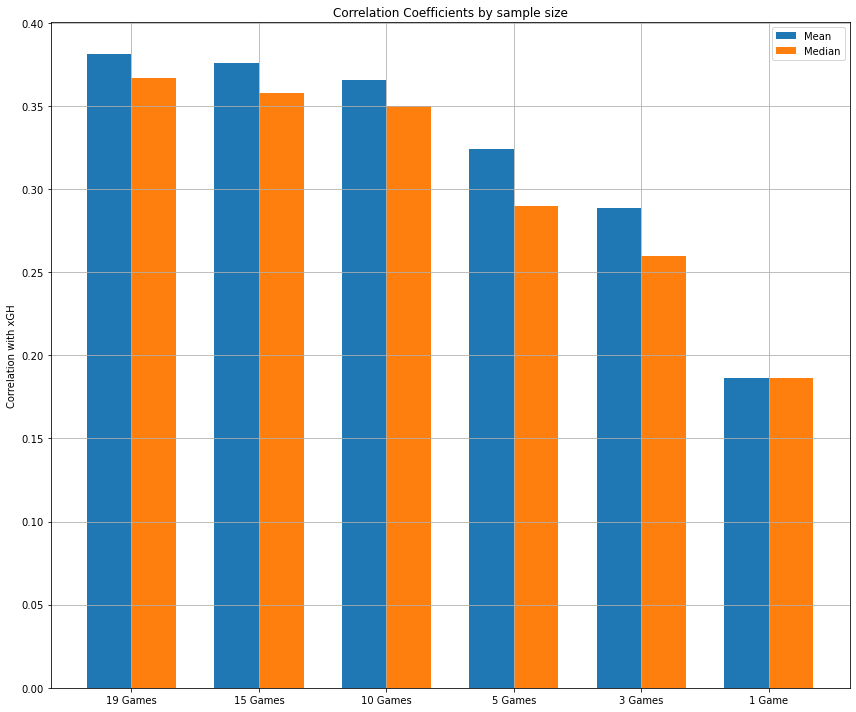

In [44]:
#groups for the bar chart
labels = ['19 Games', '15 Games', '10 Games', '5 Games', '3 Games','1 Game']
#adding correlation coeffs to a list
means = [home_scored_df_testing['19_game_mean'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['15_game_mean'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['10_game_mean'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['5_game_mean'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['3_game_mean'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['1_game_mean'].corr(home_scored_df_testing['xGH'])]
medians = [home_scored_df_testing['19_game_median'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['15_game_median'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['10_game_median'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['5_game_median'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['3_game_median'].corr(home_scored_df_testing['xGH']),home_scored_df_testing['1_game_median'].corr(home_scored_df_testing['xGH'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means, width, label='Mean')
rects2 = ax.bar(x + width/2, medians, width, label='Median')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation with xGH')
ax.set_title('Correlation Coefficients by sample size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)

fig.tight_layout()

plt.show()

From the above, it is clear that the median performs worse in every case. It is also clear that that the longer the time period used, the stronger the correlation. It is also clear that the mean out-performs the median in every case. To move forward, I drop all median metrics, as well as the one game and two game means. In the calls below, these means are created for home defensive strength, away attacking strength and away defensive strength.

In [45]:
# follow identical process with home XG conceded (which is the XGA)
#create a subset of the main dataframe, with only the attributes needed to track the home expected goals (conceded) over time
home_conceded_df = df.loc[:, ['home_team','xGA','home_game_counter_all']]

#as we want to understand how well the team did relative to the average home performance, we divide all columns by the mean
x = home_conceded_df['xGA'].mean()
home_conceded_df['xGA'] = home_conceded_df['xGA'] / x

#create metrics by grouping according to team and applying a transformation to the xGA column 

home_conceded_df['19_game_mean'] = home_conceded_df.groupby('home_team')['xGA'].transform(lambda x: x.rolling(19,10).mean())
home_conceded_df['15_game_mean'] = home_conceded_df.groupby('home_team')['xGA'].transform(lambda x: x.rolling(15,10).mean())
home_conceded_df['10_game_mean'] = home_conceded_df.groupby('home_team')['xGA'].transform(lambda x: x.rolling(10).mean())
home_conceded_df['5_game_mean'] = home_conceded_df.groupby('home_team')['xGA'].transform(lambda x: x.rolling(5).mean())

#create a seperate df with just the results. We will merge the transformed data back into this one afterwards
home_conceded_df_results = home_conceded_df.loc[:, ['home_team','xGA','home_game_counter_all']]

#create a unique index which can be used to match the games when merging back in

#change home game counter to string to allow it to be combined: 
home_conceded_df_results['home_game_counter_all'] = home_conceded_df_results['home_game_counter_all'].astype(str)

#combine the two columns to create a unique index
home_conceded_df_results['team+counter'] = home_conceded_df_results['home_team'] + '_' + home_conceded_df_results['home_game_counter_all']

#create another seperate df with just the metrics
home_conceded_df_metrics = home_conceded_df.drop(['xGA'], axis = 1)

#add 1 to all of the home_game counters
home_conceded_df_metrics['home_game_counter_all'] = home_conceded_df_metrics['home_game_counter_all'].add(1)

#create a matching index to the results df
home_conceded_df_metrics['home_game_counter_all'] = home_conceded_df_metrics['home_game_counter_all'].astype(str)
home_conceded_df_metrics['team+counter'] = home_conceded_df_metrics['home_team'] + '_' + home_conceded_df_metrics['home_game_counter_all']

#drop the columns we will not use in the merge
home_conceded_df_metrics.drop(['home_team','home_game_counter_all'],axis = 1 , inplace = True)

#merge the dataframes
home_conceded_df_testing = home_conceded_df_results.merge(home_conceded_df_metrics, on = 'team+counter')
#note: this merge will drop the rows with 115, but this is intended, we would not be using them in our analysis yesterday

#round the df for readability
home_conceded_df_testing = home_conceded_df_testing.round(2)

In [46]:
# follow identical process with away xG scored (which is the XGA)
#create a subset of the main dataframe, with only the attributes needed to track the home expected goals (scored) over time
away_scored_df = df.loc[:, ['away_team','xGA','away_game_counter_all']]

#as we want to understand how well the team did relative to the average home performance, we divide all columns by the mean
x = away_scored_df['xGA'].mean()
away_scored_df['xGA'] = away_scored_df['xGA'] / x

#create metrics by grouping according to team and applying a transformation to the xGA column 

away_scored_df['19_game_mean'] = away_scored_df.groupby('away_team')['xGA'].transform(lambda x: x.rolling(19,10).mean())
away_scored_df['15_game_mean'] = away_scored_df.groupby('away_team')['xGA'].transform(lambda x: x.rolling(15,10).mean())
away_scored_df['10_game_mean'] = away_scored_df.groupby('away_team')['xGA'].transform(lambda x: x.rolling(10).mean())
away_scored_df['5_game_mean'] = away_scored_df.groupby('away_team')['xGA'].transform(lambda x: x.rolling(5).mean())

#create a seperate df with just the results. We will merge the transformed data back into this one afterwards
away_scored_df_results = away_scored_df.loc[:, ['away_team','xGA','away_game_counter_all']]

#create a unique index which can be used to match the games when merging back in

#change home game counter to string to allow it to be combined: 
away_scored_df_results['away_game_counter_all'] = away_scored_df_results['away_game_counter_all'].astype(str)

#combine the two columns to create a unique index
away_scored_df_results['team+counter'] = away_scored_df_results['away_team'] + '_' + away_scored_df_results['away_game_counter_all']

#create another seperate df with just the metrics
away_scored_df_metrics = away_scored_df.drop(['xGA'], axis = 1)

#add 1 to all of the away_game counters
away_scored_df_metrics['away_game_counter_all'] = away_scored_df_metrics['away_game_counter_all'].add(1)

#create a matching index to the results df
away_scored_df_metrics['away_game_counter_all'] = away_scored_df_metrics['away_game_counter_all'].astype(str)
away_scored_df_metrics['team+counter'] = away_scored_df_metrics['away_team'] + '_' + away_scored_df_metrics['away_game_counter_all']

#drop the columns we will not use in the merge
away_scored_df_metrics.drop(['away_team','away_game_counter_all'],axis = 1 , inplace = True)

#merge the dataframes
away_scored_df_testing = away_scored_df_results.merge(away_scored_df_metrics, on = 'team+counter')

#round the df for readability
away_scored_df_testing = away_scored_df_testing.round(2)


In [47]:
# follow identical process with away XG conceded (which is the XGH)
#create a subset of the main dataframe, with only the attributes needed to track the home expected goals (conceded) over time
away_conceded_df = df.loc[:, ['away_team','xGH','away_game_counter_all']]

#as we want to understand how well the team did relative to the average home performance, we divide all columns by the mean
x = away_conceded_df['xGH'].mean()
away_conceded_df['xGH'] = away_conceded_df['xGH'] / x
away_conceded_df

#create metrics by grouping according to team and applying a transformation to the xGA column 

away_conceded_df['19_game_mean'] = away_conceded_df.groupby('away_team')['xGH'].transform(lambda x: x.rolling(19,10).mean())
away_conceded_df['15_game_mean'] = away_conceded_df.groupby('away_team')['xGH'].transform(lambda x: x.rolling(15,10).mean())
away_conceded_df['10_game_mean'] = away_conceded_df.groupby('away_team')['xGH'].transform(lambda x: x.rolling(10).mean())
away_conceded_df['5_game_mean'] = away_conceded_df.groupby('away_team')['xGH'].transform(lambda x: x.rolling(5).mean())


#create a seperate df with just the results. We will merge the transformed data back into this one afterwards
away_conceded_df_results = away_conceded_df.loc[:, ['away_team','xGH','away_game_counter_all']]

#create a unique index which can be used to match the games when merging back in

#change home game counter to string to allow it to be combined: 
away_conceded_df_results['away_game_counter_all'] = away_conceded_df_results['away_game_counter_all'].astype(str)

#combine the two columns to create a unique index
away_conceded_df_results['team+counter'] = away_conceded_df_results['away_team'] + '_' + away_conceded_df_results['away_game_counter_all']

#create another seperate df with just the metrics
away_conceded_df_metrics = away_conceded_df.drop(['xGH'], axis = 1)

#add 1 to all of the away_game counters
away_conceded_df_metrics['away_game_counter_all'] = away_conceded_df_metrics['away_game_counter_all'].add(1)

#create a matching index to the results df
away_conceded_df_metrics['away_game_counter_all'] = away_conceded_df_metrics['away_game_counter_all'].astype(str)
away_conceded_df_metrics['team+counter'] = away_conceded_df_metrics['away_team'] + '_' + away_conceded_df_metrics['away_game_counter_all']

#drop the columns we will not use in the merge
away_conceded_df_metrics.drop(['away_team','away_game_counter_all'],axis = 1 , inplace = True)

#merge the dataframes
away_conceded_df_testing = away_conceded_df_results.merge(away_conceded_df_metrics, on = 'team+counter')
#note: this merge will drop the rows with 115, but this is intended, we would not be using them in our analysis yesterday

#round the df for readability
away_conceded_df_testing = away_conceded_df_testing.round(2)

Now, we will merge thes eback into the main dataframe. First, we will need to tidy them up. Again, we will be using the 'team+counter as the unique index.  

In [48]:
#drop redundant columns
home_scored_df_testing.drop(['home_team','xGH','home_game_counter_all'], axis = 1 , inplace = True)

#rename the columns to ensure they are recognisable after the merge. 
home_scored_df_testing.rename(columns = {'19_game_mean':'home_scored_19_mean',
                     '15_game_mean':'home_scored_15_mean',
                     '10_game_mean':'home_scored_10_mean',
                     '5_game_mean':'home_scored_5_mean',
                    'team+counter': 'home_team+counter' #only unique if it references home, otherwise duplicates
                     },inplace = True)

#drop redundant columns
home_conceded_df_testing.drop(['home_team','xGA','home_game_counter_all'], axis = 1 , inplace = True)

#rename the columns to ensure they are recognisable after the merge. 
home_conceded_df_testing.rename(columns = {'19_game_mean':'home_conceded_19_mean',
                     '15_game_mean':'home_conceded_15_mean',
                     '10_game_mean':'home_conceded_10_mean',
                     '5_game_mean':'home_conceded_5_mean',
                    'team+counter': 'home_team+counter' #only unique if it references home, otherwise duplicates
                     },inplace = True)

#drop redundant columns
away_scored_df_testing.drop(['away_team','xGA','away_game_counter_all'], axis = 1 , inplace = True)

#rename the columns to ensure they are recognisable after the merge. 
away_scored_df_testing.rename(columns = {'19_game_mean':'away_scored_19_mean',
                     '15_game_mean':'away_scored_15_mean',
                     '10_game_mean':'away_scored_10_mean',
                     '5_game_mean':'away_scored_5_mean',
                    'team+counter': 'away_team+counter' #only unique if it references away, otherwise duplicates
                     },inplace = True)


#drop redundant columns
away_conceded_df_testing.drop(['away_team','xGH','away_game_counter_all'], axis = 1 , inplace = True)

#rename the columns to ensure they are recognisable after the merge. 
away_conceded_df_testing.rename(columns = {'19_game_mean':'away_conceded_19_mean',
                     '15_game_mean':'away_conceded_15_mean',
                     '10_game_mean':'away_conceded_10_mean',
                     '5_game_mean':'away_conceded_5_mean',
                    'team+counter': 'away_team+counter' #only unique if it references away, otherwise duplicates
                     },inplace = True)



In [49]:
#create an identical index to allow merge
df['home_game_counter_all'] = df['home_game_counter_all'].astype(str)
df['away_game_counter_all'] = df['away_game_counter_all'].astype(str)


df['away_team+counter'] = df['away_team'] +'_'+ df['away_game_counter_all'] 
df['home_team+counter'] = df['home_team'] +'_'+ df['home_game_counter_all'] 

In [50]:
#merge new metrics into the main df
df = df.merge(home_scored_df_testing, on = 'home_team+counter' , how = 'left')
df = df.merge(home_conceded_df_testing, on = 'home_team+counter' , how = 'left')
df = df.merge(away_scored_df_testing, on = 'away_team+counter' , how = 'left')
df = df.merge(away_conceded_df_testing, on = 'away_team+counter' , how = 'left')


# PART 3: Analysing xG

## - Assesing the correlation between goals and xG within a given game
## - Plotting xG and actual goals achievced across the course of a season to understand correlation
## - Creating a simple 'repeatability test' by assessing correlation between the first half and second half of the season

The cell below shows a simple correlation between the xG and goals columns in the dataframe

In [51]:
print('Correlation of xGH and goals scored at home: ' + str(round(df['xGH'].corr(df['home_goals']),2)))
print('Correlation of xGA and goals conceded at home: ' + str(round(df['xGA'].corr(df['away_goals']),2)))

Correlation of xGH and goals scored at home: 0.64
Correlation of xGA and goals conceded at home: 0.64


The cell below plots a team's average home xG for the season against it's average home goals for the season, both for and against. 

In [52]:
#selects the columns and creates a seperate df
r_df_h = df.loc[:,['year','home_team','xGH','xGA','home_goals','away_goals']]

#create an index of home team + year
r_df_h['home_team_year'] = r_df_h['home_team'] +'_'+ r_df_h['year']

#drop the now-redundant columns
r_df_h.drop(['home_team','year'],axis = 1, inplace = True)

#groupby home team and show averages of all remaining columns
season_avs = r_df_h.groupby('home_team_year').mean()

season_avs = season_avs.round(2)

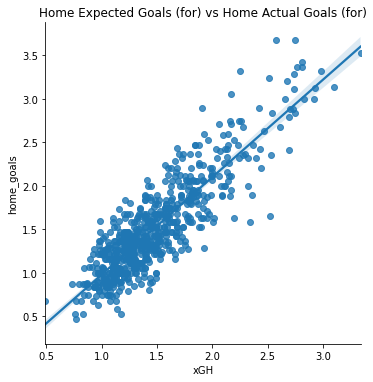

In [53]:
import seaborn as sns
sns.lmplot(x = 'xGH', y = 'home_goals', data=season_avs).set(title='Home Expected Goals (for) vs Home Actual Goals (for)')


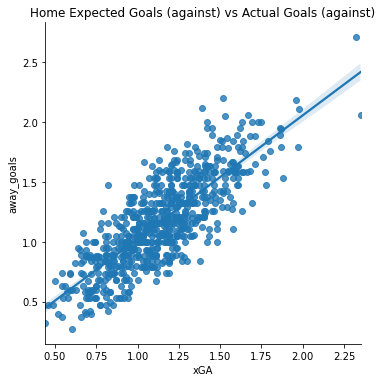

In [54]:
sns.lmplot(x = 'xGA', y = 'away_goals', data=season_avs).set(title='Home Expected Goals (against) vs Actual Goals (against)')

The cell below plots a team's average away xG for the season against it's away average goals for the season, both for and against. 

In [55]:
#selects the columns and creates a seperate df
r_df_a = df.loc[:,['year','away_team','xGH','xGA','home_goals','away_goals']]

#create an index of home team + year
r_df_a['away_team_year'] = r_df_a['away_team'] +'_'+ r_df_a['year']

#drop the now-redundant columns
r_df_a.drop(['away_team','year'],axis = 1, inplace = True)

#groupby home team and show averages of all remaining columns
season_avs_a = r_df_a.groupby('away_team_year').mean()

season_avs_a = season_avs_a.round(2)

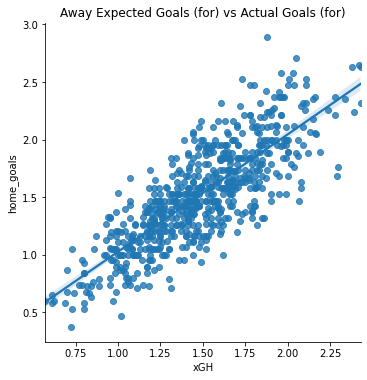

In [56]:
sns.lmplot(x = 'xGH', y = 'home_goals', data=season_avs_a).set(title='Away Expected Goals (for) vs Actual Goals (for)')

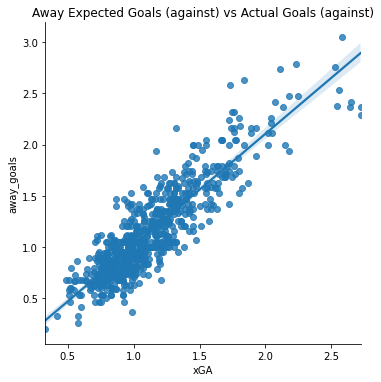

In [57]:
sns.lmplot(x = 'xGA', y = 'away_goals', data=season_avs_a).set(title='Away Expected Goals (against) vs Actual Goals (against)')

In [58]:
#plot the correlation coefficients
print('Correlation of xGH and goals scored at home (season average): ' + str(round(season_avs['xGH'].corr(season_avs['home_goals']),2)))
print('Correlation of xGA and goals conceded at home (season average): ' + str(round(season_avs['xGA'].corr(season_avs['away_goals']),2)))
print('Corrleation of xGA and goals scored away (season average): ' + str(round(season_avs_a['xGA'].corr(season_avs_a['away_goals']),2)))
print('Corrleation of xGH and goals conceded away (season average): ' + str(round(season_avs_a['xGH'].corr(season_avs_a['home_goals']),2)))


Correlation of xGH and goals scored at home (season average): 0.87
Correlation of xGA and goals conceded at home (season average): 0.8
Corrleation of xGA and goals scored away (season average): 0.88
Corrleation of xGH and goals conceded away (season average): 0.81


The cells below conduct a simple repeatability test, assessing how well-correlated a teams xG in the first half of the season is with it's xG in the second half of the season. The result is compared to using goals alone. 

In [59]:
#create a new dataframe to include the home team performance
rep_df_h = df.loc[:,['year','home_team','xGH','xGA','home_goals','away_goals','home_game_counter']]

#create an index of home team + year
rep_df_h['home_team_year'] = rep_df_h['home_team'] +'_'+ rep_df_h['year']

#drop the now-redundant columns
rep_df_h.drop(['home_team','year'],axis = 1, inplace = True)

#split data into two halfs based on game counter
red_df_h_low = rep_df_h.loc[rep_df_h['home_game_counter']<8]
red_df_h_high = rep_df_h.loc[rep_df_h['home_game_counter']>8]

#drop the redundant game counters
red_df_h_low.drop(['home_game_counter'], axis = 1 , inplace = True)
red_df_h_high.drop(['home_game_counter'], axis = 1 , inplace = True)

#groupby the index and take the mean
first_half_season_avs = red_df_h_low.groupby('home_team_year').mean()
second_half_season_avs = red_df_h_high.groupby('home_team_year').mean()

first_half_season_avs.rename(columns={"xGH": "first_half_xGH", "xGA": "first_half_xGA", "home_goals":"first_half_home_goals","away_goals":"first_half_home_goals_conceded"},inplace = True)
second_half_season_avs.rename(columns={"xGH": "second_half_xGH", "xGA": "second_half_xGA", "home_goals":"second_half_home_goals","away_goals":"second_half_home_goals_conceded"}, inplace = True)

C:\Users\jowen\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
repeatability_df_home = first_half_season_avs.merge(second_half_season_avs, on = 'home_team_year')

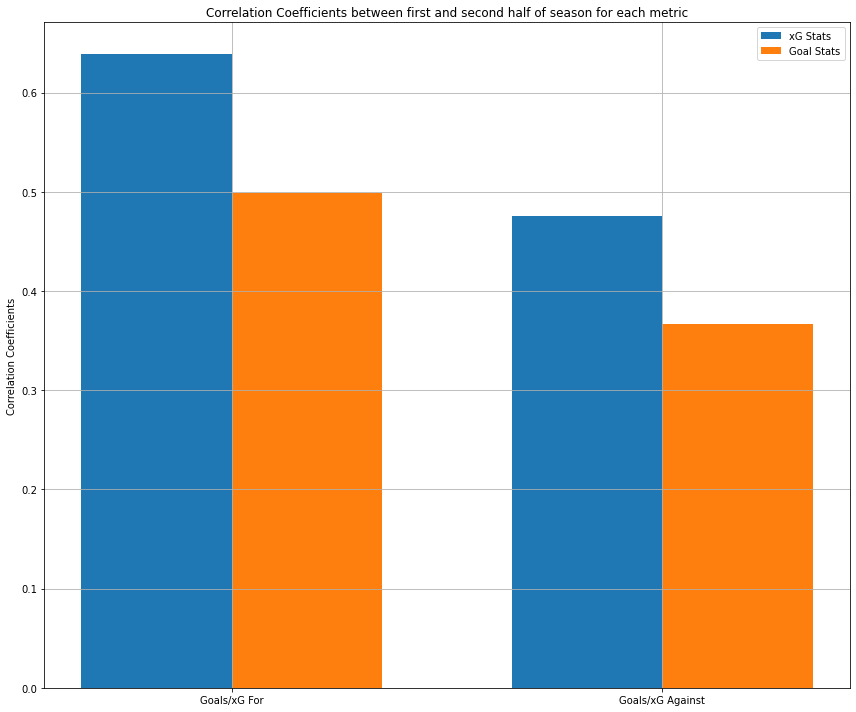

In [61]:
#groups for the bar chart
labels = ['Goals/xG For','Goals/xG Against']
#adding correlation coeffs to a list
xG_stats = [repeatability_df_home['first_half_xGH'].corr(repeatability_df_home['second_half_xGH']),repeatability_df_home['first_half_xGA'].corr(repeatability_df_home['second_half_xGA'])]
goal_stats = [repeatability_df_home['first_half_home_goals'].corr(repeatability_df_home['second_half_home_goals']),repeatability_df_home['first_half_home_goals_conceded'].corr(repeatability_df_home['second_half_home_goals_conceded'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, xG_stats, width, label='xG Stats')
rects2 = ax.bar(x + width/2, goal_stats, width, label='Goal Stats')

ax.set_ylabel('Correlation Coefficients')
ax.set_title('Correlation Coefficients between first and second half of season for each metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)

fig.tight_layout()



plt.show()

# PART 4: Further Analysis/Machine Learning 

## - Creating a 'simple' predicted goals using the metrics
## - Using Linear Regression to understand the realtionship between the attacking and defensive strengths and xG
## - Using the outputs of the regresison model to calculate a regression-based predicted goals
## - Using KNN to predict the outcome of a match
## - Adapting KNN to predict the winner in terms of xG
## - Assessing the usefulness of the Poisson distribution

In the cells below, a 'simple' formula is used to create a 'predicted goals'

In [62]:
# all metrics created with reference to the average home and away performance, so we define themm here
a = df['xGH'].mean()
b = df['xGA'].mean()

#calculate this for 19 game mean
df['home_goal_expectancy_19'] = df['home_scored_19_mean'] * df['away_conceded_19_mean'] * a
df['away_goal_expectancy_19'] = df['away_scored_19_mean'] * df['home_conceded_19_mean'] * b

#15 game mean 
df['home_goal_expectancy_15'] = df['home_scored_15_mean'] * df['away_conceded_15_mean'] * a
df['away_goal_expectancy_15'] = df['away_scored_15_mean'] * df['home_conceded_15_mean'] * b

#10 game mean
df['home_goal_expectancy_10'] = df['home_scored_10_mean'] * df['away_conceded_10_mean'] * a
df['away_goal_expectancy_10'] = df['away_scored_10_mean'] * df['home_conceded_10_mean'] * b

#5 game mean
df['home_goal_expectancy_5'] = df['home_scored_5_mean'] * df['away_conceded_5_mean'] * a
df['away_goal_expectancy_5'] = df['away_scored_5_mean'] * df['home_conceded_5_mean'] * b

# Using Linear Regression to calculate coefficients

In the simple version of the model, we simply substitute the relative strengths into the the formula for 'Predicted Goals'. However, it may be possible to improve the accuracy of this model by treating the goal expectation as the dependant variable and using linear regression to estimate the coefficients on attacking and defensive strength. The cells below use Liner Regression to fit the relationship between the strengths and xG, and output some common assesments such as r2. 

In [63]:
from sklearn.linear_model import LinearRegression

#drop nan
df1= df.dropna()

#create dependant/independant variables. To start with, we will use only the home goals scored. 

dependent = df1[['xGH']]
independent = df1[['home_scored_19_mean','away_conceded_19_mean']]

y = dependent
x = independent

# fit the data using linear regression:
linreg = LinearRegression()
linreg.fit(x,y)

y_pred = linreg.predict(x)

import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

r_squared = r2_score(y, y_pred)
MSE = mean_squared_error(y, y_pred)
MAE = mean_absolute_error(y, y_pred)
RMSE = math.sqrt(MSE)

print("R Squared: ", round(r_squared,2))
print("MSE: ", round(MSE,2))
print("MAE: ", round(MAE,2))
print("RMSE: ", round(RMSE,2))

R Squared:  0.19
MSE:  0.63
MAE:  0.62
RMSE:  0.79


This Linear Regression produces a reasonable result. Although the r2 is relatively low, this is to be expected given the amount of 'noise' in football results. The RMSE is also high, but again is a reasonable value in context. We can repeat this for the away xG, to check the relationship is similar. 

In [64]:
#create dependant/independant variables to assess the correlation to xGA
dependent = df1[['xGA']]
independent = df1[['away_scored_19_mean','home_conceded_19_mean']]

y = dependent
x = independent

# fit the data using linear regression:
linreg.fit(x,y)

y_pred = linreg.predict(x)

print("R Squared: ", round(r_squared,2))
print("MSE: ", round(MSE,2))
print("MAE: ", round(MAE,2))
print("RMSE: ", round(RMSE,2))

R Squared:  0.19
MSE:  0.63
MAE:  0.62
RMSE:  0.79


This gives similar values to the home xG, which is the expected result. 

#### Using the output of linear regression to estimate Predicted Goals:

In [65]:
#Estimating the paramaters for the 19 game mean strengths.

#set the x and y variables, using the 19 game mean (home xG)
y_19_h = df1[['xGH']]
x_19_h = df1[['home_scored_19_mean','away_conceded_19_mean']]

#fit the model using these parameters
line_19_h = linreg.fit(x_19_h,y_19_h)

#this print statement creates an 'equation' for the xG estimate, using the intercept_ and coef_ functions since these functions return arrays, we use [0] and [1] to access the values themselves
print('Predicted xGH for 19 Game mean: ' + str(round(line_19_h.intercept_[0],2)) + ' + ' + str(round(line_19_h.coef_[0][0],2)) +'(home_scored_19_mean)'+ ' + '+ str(round(line_19_h.coef_[0][1],2))+'(away_conceded_19_mean)'  )


Predicted xGH for 19 Game mean: -0.49 + 1.12(home_scored_19_mean) + 0.86(away_conceded_19_mean)


In [66]:
#set the x and y variables, using the 19 game mean (away xG)
y_19_a = df1[['xGA']]
x_19_a = df1[['away_scored_19_mean','home_conceded_19_mean']]

#fit the model using these parameters
line_19_a = linreg.fit(x_19_a,y_19_a)

print('Predicted xGA for 19 Game mean: ' + str(round(line_19_a.intercept_[0],2)) + ' + ' + str(round(line_19_a.coef_[0][0],2)) +'(away_scored_19_mean)'+ ' + '+ str(round(line_19_a.coef_[0][1],2))+'(home_conceded_19_mean)'  )

Predicted xGA for 19 Game mean: -0.33 + 0.87(away_scored_19_mean) + 0.62(home_conceded_19_mean)


In [67]:
#set the x and y variables, using the 15 game mean (home xG)
y_15_h = df1[['xGH']]
x_15_h = df1[['home_scored_15_mean','away_conceded_15_mean']]

#fit the model using these parameters
line_15_h = linreg.fit(x_15_h,y_15_h)

print('Predicted xGH for 15 Game mean: ' + str(round(line_15_h.intercept_[0],2)) + ' + ' + str(round(line_15_h.coef_[0][0],2)) +'(home_scored_15_mean)'+ ' + '+ str(round(line_15_h.coef_[0][1],2))+'(away_conceded_15_mean)'  )


Predicted xGH for 15 Game mean: -0.41 + 1.07(home_scored_15_mean) + 0.82(away_conceded_15_mean)


In [68]:
#set the x and y variables, using the 15 game mean (away xG)
y_15_a = df1[['xGA']]
x_15_a = df1[['away_scored_15_mean','home_conceded_15_mean']]

#fit the model using these parameters
line_15_a = linreg.fit(x_15_a,y_15_a)

#this print statement creates an 'equation' for the xG estimate, using the intercept_ and coef_ functions since these functions return arrays, we use [0] and [1] to access the values themselves
print('Predicted xGA for 15 Game mean: ' + str(round(line_15_a.intercept_[0],2)) + ' + ' + str(round(line_15_a.coef_[0][0],2)) +'(away_scored_15_mean)'+ ' + '+ str(round(line_15_a.coef_[0][1],2))+'(home_conceded_15_mean)'  )

Predicted xGA for 15 Game mean: -0.25 + 0.83(away_scored_15_mean) + 0.57(home_conceded_15_mean)


In [69]:
#Estimating the paramaters for the 10 game mean strengths.

#set the x and y variables, using the 10 game mean (home xG)
y_10_h = df1[['xGH']]
x_10_h = df1[['home_scored_10_mean','away_conceded_10_mean']]

#fit the model using these parameters
line_10_h = linreg.fit(x_10_h,y_10_h)

print('Predicted xGH for 10 Game mean: ' + str(round(line_10_h.intercept_[0],2)) + ' + ' + str(round(line_10_h.coef_[0][0],2)) +'(home_scored_10_mean)'+ ' + '+ str(round(line_10_h.coef_[0][1],2))+'(away_conceded_10_mean)'  )


Predicted xGH for 10 Game mean: -0.21 + 1.0(home_scored_10_mean) + 0.69(away_conceded_10_mean)


In [70]:

#set the x and y variables, using the 10 game mean (away xG)
y_10_a = df1[['xGA']]
x_10_a = df1[['away_scored_10_mean','home_conceded_10_mean']]

#fit the model using these parameters
line_10_a = linreg.fit(x_10_a,y_10_a)

print('Predicted xGA for 10 Game mean: ' + str(round(line_10_a.intercept_[0],2)) + ' + ' + str(round(line_10_a.coef_[0][0],2)) +'(away_scored_10_mean)'+ ' + '+ str(round(line_10_a.coef_[0][1],2))+'(home_conceded_10_mean)'  )

Predicted xGA for 10 Game mean: -0.08 + 0.75(away_scored_10_mean) + 0.48(home_conceded_10_mean)


In [71]:
#Estimating the paramaters for the 5 game mean strengths.

#set the x and y variables, using the 5 game mean (home xG)
y_5_h = df1[['xGH']]
x_5_h = df1[['home_scored_5_mean','away_conceded_5_mean']]

#fit the model using these parameters
line_5_h = linreg.fit(x_5_h,y_5_h)

print('Predicted xGH for 5 Game mean: ' + str(round(line_5_h.intercept_[0],2)) + ' + ' + str(round(line_5_h.coef_[0][0],2)) +'(home_scored_5_mean)'+ ' + '+ str(round(line_5_h.coef_[0][1],2))+'(away_conceded_5_mean)'  )


Predicted xGH for 5 Game mean: 0.18 + 0.79(home_scored_5_mean) + 0.5(away_conceded_5_mean)


In [72]:
#set the x and y variables, using the 5 game mean (away xG)
y_5_a = df1[['xGA']]
x_5_a = df1[['away_scored_5_mean','home_conceded_5_mean']]

#fit the model using these parameters
line_5_a = linreg.fit(x_5_a,y_5_a)

print('Predicted xGA for 5 Game mean: ' + str(round(line_5_a.intercept_[0],2)) + ' + ' + str(round(line_5_a.coef_[0][0],2)) +'(away_scored_5_mean)'+ ' + '+ str(round(line_5_a.coef_[0][1],2))+'(home_conceded_5_mean)'  )

Predicted xGA for 5 Game mean: 0.22 + 0.58(away_scored_5_mean) + 0.35(home_conceded_5_mean)


#### Calculate new 'Goal Expectancies' using formaulas above

In [73]:
#calculate this for 19 game mean
df['home_goal_expectancy_19_reg'] = (-0.49) + (1.12*(df['home_scored_19_mean'])) + (0.86*(df['away_conceded_19_mean']))
df['away_goal_expectancy_19_reg'] = (-0.33) + (0.87*(df['away_scored_19_mean'])) + (0.62*(df['home_conceded_19_mean']))

#calculate this for 15 game mean
df['home_goal_expectancy_15_reg'] = (-0.41) + (1.07*(df['home_scored_15_mean'])) + (0.82*(df['away_conceded_15_mean']))
df['away_goal_expectancy_15_reg'] = (-0.25) + (0.83*(df['away_scored_15_mean'])) + (0.57*(df['home_conceded_15_mean']))

#calculate this for 10 game mean
df['home_goal_expectancy_10_reg'] = (-0.21) + (1*(df['home_scored_10_mean'])) + (0.69*(df['away_conceded_10_mean']))
df['away_goal_expectancy_10_reg'] = (-0.08) + (0.75*(df['away_scored_10_mean'])) + (0.48*(df['home_conceded_10_mean']))

#calcualte this for 5 game mean 
df['home_goal_expectancy_5_reg'] = (-0.18) + (0.79*(df['home_scored_5_mean'])) + (0.5*(df['away_conceded_5_mean']))
df['away_goal_expectancy_5_reg'] = (-0.22) + (0.58*(df['away_scored_5_mean'])) + (0.35*(df['home_conceded_5_mean']))

The cells below plot a graph to compare the correlation coefficients achieved by different versions of the model with xG, grouped by the number of games used. 

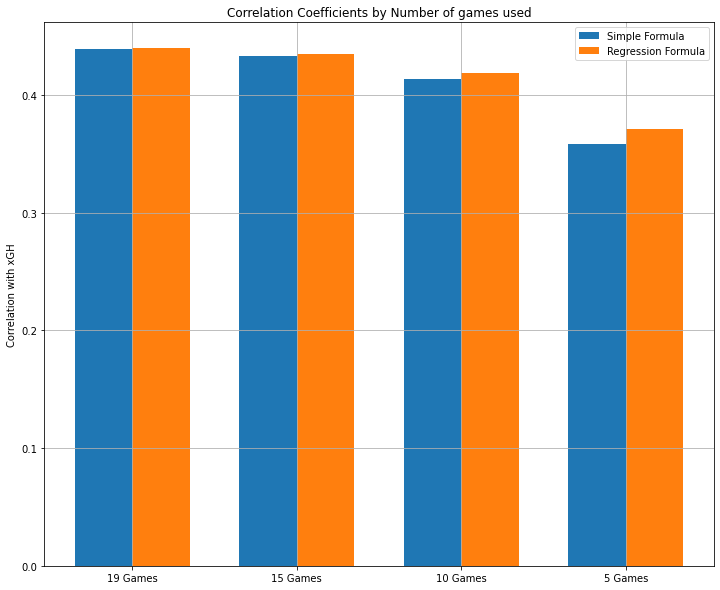

In [74]:
#groups for the bar chart
labels = ['19 Games', '15 Games', '10 Games', '5 Games']
#adding correlation coeffs to a list
Simple_Formula = [df['home_goal_expectancy_19'].corr(df['xGH']),df['home_goal_expectancy_15'].corr(df['xGH']),df['home_goal_expectancy_10'].corr(df['xGH']),df['home_goal_expectancy_5'].corr(df['xGH'])]
Regression_Formula = [df['home_goal_expectancy_19_reg'].corr(df['xGH']),df['home_goal_expectancy_15_reg'].corr(df['xGH']),df['home_goal_expectancy_10_reg'].corr(df['xGH']),df['home_goal_expectancy_5_reg'].corr(df['xGH'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Simple_Formula, width, label='Simple Formula')
rects2 = ax.bar(x + width/2, Regression_Formula, width, label='Regression Formula')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation with xGH')
ax.set_title('Correlation Coefficients by Number of games used')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True)



plt.show()

#### Predict the absolute outcome of a game using the KNN model

In [75]:
df1 = df.dropna()

#define feature and target data 
target_data =df1.loc[:,['result']]
#use 19 game mean (regression) , as this had the strongest correlation
feature_data = df1.loc[:,['home_goal_expectancy_19_reg','away_goal_expectancy_19_reg']]

[Text(0.5, 1.0, 'Away Predicted Goals vs Home Predcited Goals Goals')]

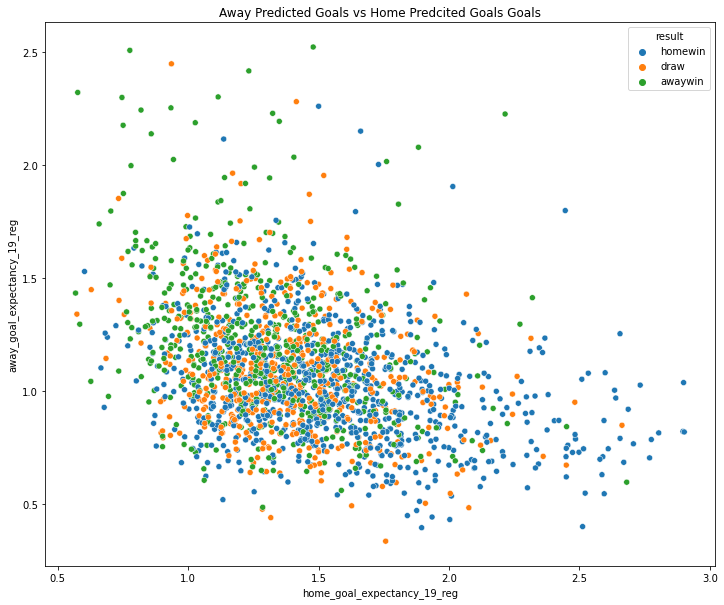

In [76]:
import seaborn as sns
sns.scatterplot(x = 'home_goal_expectancy_19_reg', y = 'away_goal_expectancy_19_reg', data=df1.head(2000), hue = 'result' ).set(title='Away Predicted Goals vs Home Predcited Goals Goals')

In [77]:
x = feature_data
y = target_data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x,y)

<ipython-input-77-e15fee87c3cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(x,y)


KNeighborsClassifier(n_neighbors=4)

In [78]:
from sklearn.model_selection import train_test_split

x_train,x_test , y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 4)

In [79]:
knn.fit(x_train,y_train)

<ipython-input-79-17b0ab828d68>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(x_train,y_train)


KNeighborsClassifier(n_neighbors=4)

In [80]:
#compares the predicted test values to the real values to output an accuracy score
import sklearn.metrics as metrics
y_predict_Knn4 = knn.predict(x_test)
metrics.accuracy_score(y_test,y_predict_Knn4)

0.4339529120198265

In [81]:
#use a for-loop to understand the optimum value for K
k_range = range(1,50)

scores = []

#calculates the accuracy score for a given k-range and appends to the list
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train , np.ravel(y_train))
    y_pred = knn.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    scores.append(accuracy)

Plot the Prediction success rate against the k value used. 

Text(0.5, 1.0, 'Accuracy Score by Number of Neighbours (k) for Result')

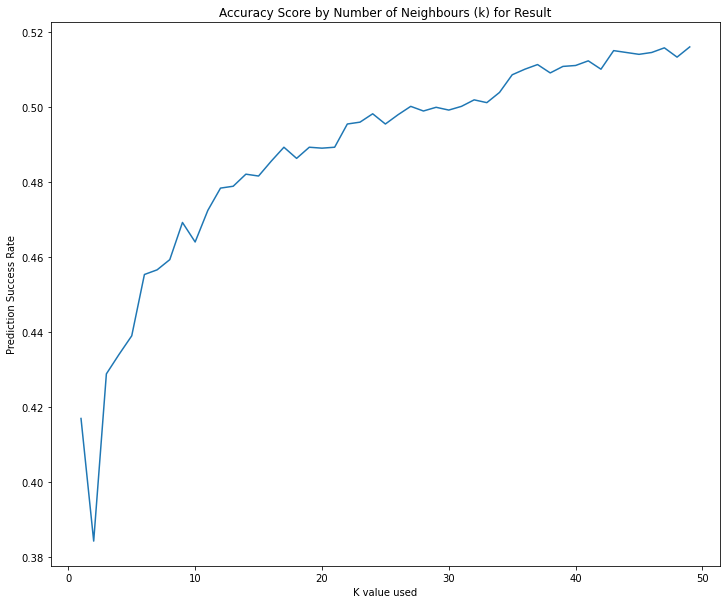

In [82]:
plt.plot(k_range,scores)

plt.ylabel('Prediction Success Rate')
plt.xlabel('K value used')
plt.title('Accuracy Score by Number of Neighbours (k) for Result')

This is a fairly unconvincing result. To try and improve the predictions of the model, we can try to use Logistic regression instead. 

In [83]:
#import logistic regresison
from sklearn.linear_model import LogisticRegression

#create a variable which holds the method and the maximum number foo iterations allowed:
logreg = LogisticRegression(max_iter=200)

#use train-test split as before
x_train,x_test , y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 4)

#fit the model 
logreg.fit(x_train,y_train)

#test the predictions
y_predict_logreg = logreg.predict(x_test)
metrics.accuracy_score(y_test,y_predict_logreg)


C:\Users\jowen\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5244114002478315

Both models have similar success rates of around 50%. The low success rate due to the high variance associated with football matches. To try and account for some of the variance, I will adjust the target data to predict which team achieved the most expected goals in the game. As we know, the winner of the game does not always achieve the most expected goals, so chaninging the target data may help to remove some of the 'noise' from the model.  

In [84]:
def xG_winner(row):
    if row['xGH'] > row['xGA']:
        val = 'home_xg_win'
    elif row['xGA'] > row['xGH']:
        val = 'away_xg_win' 
    else:
        val = 'xg_draw'
        
    return val

#create new column 'bet' using the function above
df1['xg_winner'] = df1.apply(xG_winner, axis=1)

<ipython-input-84-85689bab2710>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['xg_winner'] = df1.apply(xG_winner, axis=1)


In [85]:
target_data =df1.loc[:,['xg_winner']]
feature_data = df1.loc[:,['home_goal_expectancy_19_reg','away_goal_expectancy_19_reg']]

[Text(0.5, 1.0, 'Away Predicted Goals vs Home Predcited Goals Goals')]

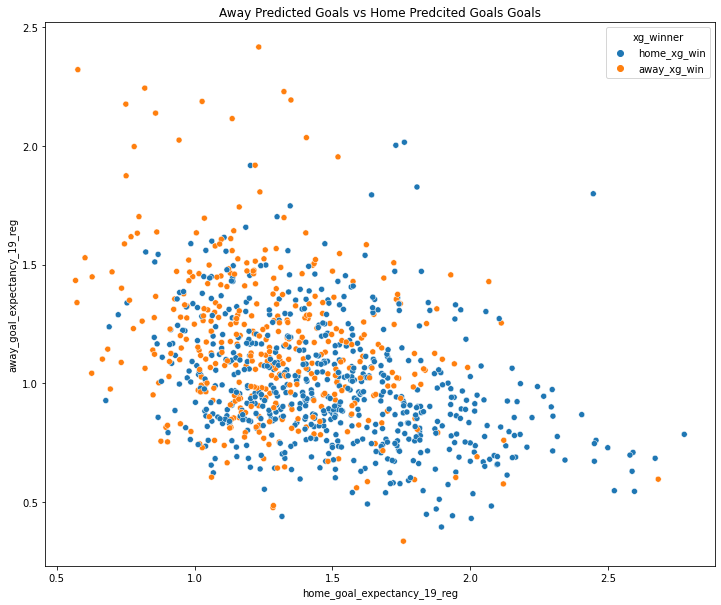

In [86]:
sns.scatterplot(x = 'home_goal_expectancy_19_reg', y = 'away_goal_expectancy_19_reg', data=df1.head(1000), hue = 'xg_winner' ).set(title='Away Predicted Goals vs Home Predcited Goals Goals')

In [87]:
x = feature_data
y = target_data

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x,y)

<ipython-input-87-e15fee87c3cf>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(x,y)


KNeighborsClassifier(n_neighbors=4)

In [88]:
from sklearn.model_selection import train_test_split

x_train,x_test , y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 4)

In [89]:
knn.fit(x_train,y_train)

<ipython-input-89-17b0ab828d68>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn.fit(x_train,y_train)


KNeighborsClassifier(n_neighbors=4)

In [90]:
import sklearn.metrics as metrics
y_predict_Knn4 = knn.predict(x_test)
metrics.accuracy_score(y_test,y_predict_Knn4)

0.5910780669144982

In [91]:
k_range = range(1,50)

scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train , np.ravel(y_train))
    y_pred = knn.predict(x_test)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    scores.append(accuracy)

Text(0.5, 1.0, 'Accuracy Score by Number of Neighbours (k) for "xG Winner"')

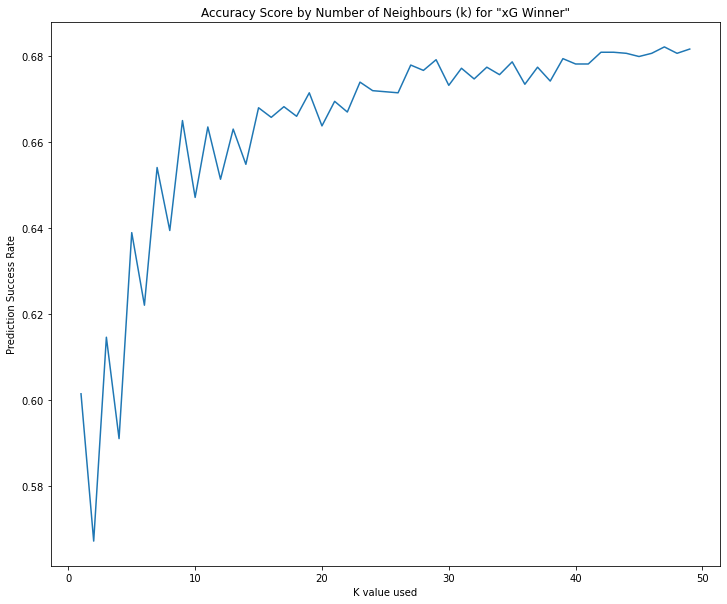

In [92]:
plt.plot(k_range,scores)
plt.ylabel('Prediction Success Rate')
plt.xlabel('K value used')
plt.title('Accuracy Score by Number of Neighbours (k) for "xG Winner"')

Once again, we can try this new target variable with Logistic Regression: 

In [93]:
#use train-test split as before
#x_train,x_test , y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 4)

#fit the model 
logreg.fit(x_train,y_train)

#test the predictions
y_predict_logreg_2 = logreg.predict(x_test)
metrics.accuracy_score(y_test,y_predict_logreg_2)


C:\Users\jowen\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.6869888475836431

As expected, predicting the winner in terms of xG alone improves the success rate of both models. 

#### Testing the validity of the Poisson distribution

Before we can use the poisson distribution to create odds, we must first check that it accurately represents the distribution of football results. 

If the poisson distribution is an accurate representation of the distribution of football results, then we would expect the 'home goals' and 'away goals' distribution to reflect the odds created when simulating the 'average' match. 


In [94]:
from scipy.stats import poisson

In [95]:
#creates a dictionary of the normalized value counts
home_goals_dict = df['home_goals'].value_counts(normalize = True).to_dict()

#converts the dictionary into a list in ascending order of goals
home_goals_list = []
for i in range(0,10):
    home_goals_list.append(round(home_goals_dict[i],3))

#creates a dictionary of the normalized value counts
away_goals_dict = df['away_goals'].value_counts(normalize = True).to_dict()

#converts the dictionary into a list in ascending order of goals
away_goals_list = []
for i in range(0,10):
    away_goals_list.append(round(away_goals_dict[i],3))


poisson_away_list = []
#creates a list of the probabilities associated with each goal when the 'predicted goals' is 1.13
for i in range(0,10):
    poisson_away_list.append(round(poisson.pmf(i,1.13),3))

#creates a list of the probabilities associated with each goal when the 'predicted goals' is 1.48    
poisson_home_list = []

for i in range(0,10):
    poisson_home_list.append(round(poisson.pmf(i,1.48),3))

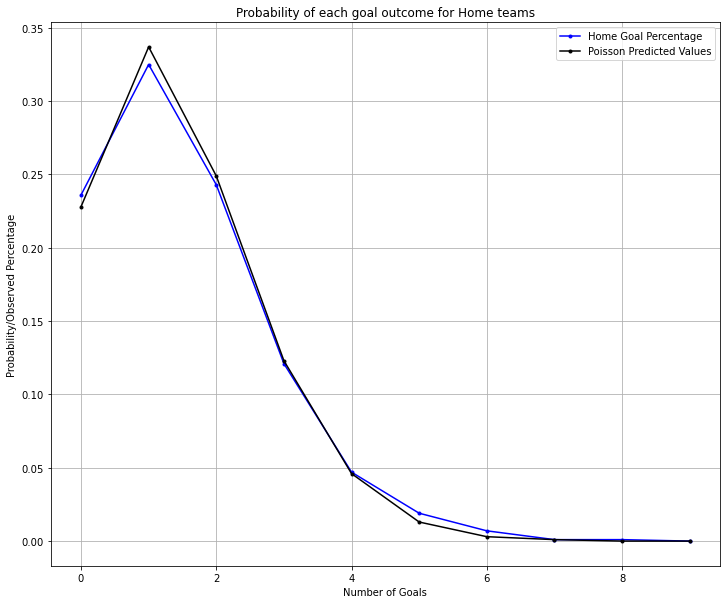

In [96]:
#plots the results on the same graph for easy comparison
plt.plot(home_goals_list,color = 'b', marker = '.', label = 'Home Goal Percentage')
plt.plot(poisson_home_list, color = 'k', marker = '.', label = 'Poisson Predicted Values')
plt.grid(True)
plt.title('Probability of each goal outcome for Home teams')
plt.ylabel('Probability/Observed Percentage')
plt.xlabel('Number of Goals')
plt.legend()

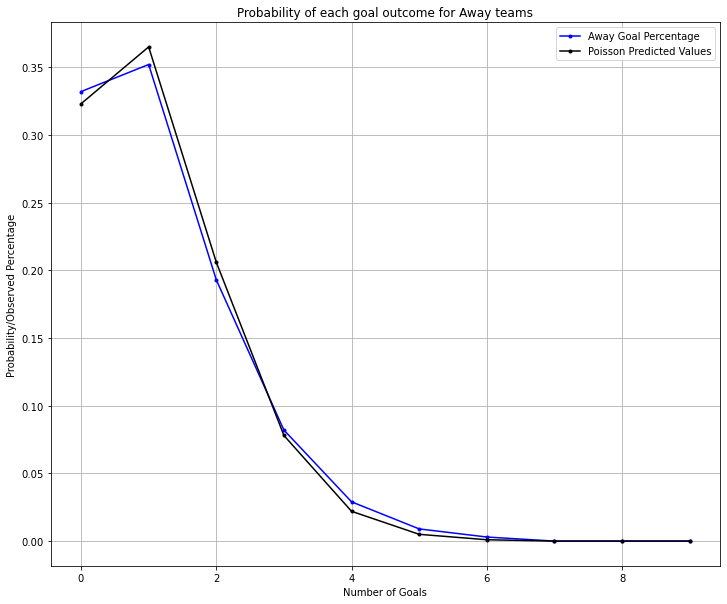

In [97]:
#plots the results on the same graph for easy comparison
plt.plot(away_goals_list,color = 'b', marker = '.', label = 'Away Goal Percentage')
plt.plot(poisson_away_list, color = 'k', marker = '.', label = 'Poisson Predicted Values')
plt.grid(True)
plt.title('Probability of each goal outcome for Away teams')
plt.ylabel('Probability/Observed Percentage')
plt.xlabel('Number of Goals')
plt.legend()
plt.show()

As we can see above, it looks as if the Poisson distribution does a good job of representing the odds. 

# PART 5: TESTING THE DATA ON PAST ODDS

## - Use the Poisson distribution to calculate the odds of each outcome, for each version of the model
## - Create a function to compare the models odds ompute an estimated 'value bet' for each game
## - Estimated an 'expected value' based on the average returns
## - Track the models performance over time
## - Adjust the model to use a higher value threshold
## - Examine the results of this adjusted model

In [98]:
from scipy.stats import poisson
import random

#### Calculate recommended bets for 19 game mean (simple):

In [99]:
#use poisson to calculate the probability for each outcome, using the 19 game means
df['home0_19'] = poisson.pmf(0, df['home_goal_expectancy_19'])
df['home1_19'] = poisson.pmf(1, df['home_goal_expectancy_19'])
df['home2_19'] = poisson.pmf(2, df['home_goal_expectancy_19'])
df['home3_19'] = poisson.pmf(3, df['home_goal_expectancy_19'])
df['home4_19'] = poisson.pmf(4, df['home_goal_expectancy_19'])
df['home5_19'] = poisson.pmf(5, df['home_goal_expectancy_19'])
df['home6_19'] = poisson.pmf(6, df['home_goal_expectancy_19'])

df['away0_19'] = poisson.pmf(0, df['away_goal_expectancy_19'])
df['away1_19'] = poisson.pmf(1, df['away_goal_expectancy_19'])
df['away2_19'] = poisson.pmf(2, df['away_goal_expectancy_19'])
df['away3_19'] = poisson.pmf(3, df['away_goal_expectancy_19'])
df['away4_19'] = poisson.pmf(4, df['away_goal_expectancy_19'])
df['away5_19'] = poisson.pmf(5, df['away_goal_expectancy_19'])
df['away6_19'] = poisson.pmf(6, df['away_goal_expectancy_19'])

#home win odds

df['home_odds_pred_19'] = round(100/((
(df['home6_19'] * df['away5_19'])+(df['home6_19'] * df['away4_19'])+(df['home6_19'] * df['away3_19'])+(df['home6_19'] * df['away2_19'])+(df['home6_19'] * df['away1_19'])+(df['home6_19'] * df['away0_19'])+
(df['home5_19'] * df['away4_19'])+(df['home5_19'] * df['away3_19'])+(df['home5_19'] * df['away2_19'])+(df['home5_19'] * df['away1_19'])+(df['home5_19'] * df['away0_19'])+
(df['home4_19'] * df['away3_19'])+(df['home4_19'] * df['away2_19'])+(df['home4_19'] * df['away1_19'])+(df['home4_19'] * df['away0_19'])+
(df['home3_19'] * df['away2_19'])+(df['home3_19'] * df['away1_19'])+(df['home3_19'] * df['away0_19'])+
(df['home2_19'] * df['away1_19'])+(df['home2_19'] * df['away1_19'])+
(df['home1_19'] * df['away0_19'])
)*100),2)

#away_win_odds
df['draw_odds_pred_19'] = round(100/((
(df['away6_19'] * df['home6_19'])+
(df['away5_19'] * df['home5_19'])+
(df['away4_19'] * df['home4_19'])+
(df['away3_19'] * df['home3_19'])+
(df['away2_19'] * df['home2_19'])+
(df['away1_19'] * df['home1_19'])+
(df['away0_19'] * df['home0_19'])
)*100),2)

#draw_win_odds
df['away_odds_pred_19'] = round(100/((
(df['away6_19'] * df['home5_19'])+(df['away6_19'] * df['home4_19'])+(df['away6_19'] * df['home3_19'])+(df['away6_19'] * df['home2_19'])+(df['away6_19'] * df['home1_19'])+(df['away6_19'] * df['home0_19'])+
(df['away5_19'] * df['home4_19'])+(df['away5_19'] * df['home3_19'])+(df['away5_19'] * df['home2_19'])+(df['away5_19'] * df['home1_19'])+(df['away5_19'] * df['home0_19'])+
(df['away4_19'] * df['home3_19'])+(df['away4_19'] * df['home2_19'])+(df['away4_19'] * df['home1_19'])+(df['away4_19'] * df['home0_19'])+
(df['away3_19'] * df['home2_19'])+(df['away3_19'] * df['home1_19'])+(df['away3_19'] * df['home0_19'])+
(df['away2_19'] * df['home1_19'])+(df['away3_19'] * df['home0_19'])+
(df['away1_19'] * df['home0_19'])
)*100),2)

#drop unused columns 
df.drop(['away0_19','away1_19','away2_19','away3_19','away4_19','away5_19','away6_19','home0_19','home1_19','home2_19','home3_19','home4_19','home5_19','home6_19','home_goal_expectancy_19','away_goal_expectancy_19'],axis=1,inplace=True)

df['home_value_estimate_19'] = df['home_odds'] / df['home_odds_pred_19']
df['draw_value_estimate_19'] = df['draw_odds'] / df['draw_odds_pred_19']
df['away_value_estimate_19'] = df['away_odds'] / df['away_odds_pred_19']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_19'] > row['draw_value_estimate_19'] and row['home_value_estimate_19'] > row['away_value_estimate_19']and row['home_value_estimate_19'] >1.05:
        val = 'home'
    elif row['away_value_estimate_19'] > row['draw_value_estimate_19'] and row['away_value_estimate_19'] > row['home_value_estimate_19']and row['away_value_estimate_19'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_19'] > row['home_value_estimate_19'] and row['draw_value_estimate_19'] > row['away_value_estimate_19']and row['draw_value_estimate_19'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_19'] = df.apply(f, axis=1)

#### Calculate recommended bets for 15 game mean (simple):

In [100]:
#use poisson to calculate the probability for each outcome, using the 15 game means
df['home0_15'] = poisson.pmf(0, df['home_goal_expectancy_15'])
df['home1_15'] = poisson.pmf(1, df['home_goal_expectancy_15'])
df['home2_15'] = poisson.pmf(2, df['home_goal_expectancy_15'])
df['home3_15'] = poisson.pmf(3, df['home_goal_expectancy_15'])
df['home4_15'] = poisson.pmf(4, df['home_goal_expectancy_15'])
df['home5_15'] = poisson.pmf(5, df['home_goal_expectancy_15'])
df['home6_15'] = poisson.pmf(6, df['home_goal_expectancy_15'])

df['away0_15'] = poisson.pmf(0, df['away_goal_expectancy_15'])
df['away1_15'] = poisson.pmf(1, df['away_goal_expectancy_15'])
df['away2_15'] = poisson.pmf(2, df['away_goal_expectancy_15'])
df['away3_15'] = poisson.pmf(3, df['away_goal_expectancy_15'])
df['away4_15'] = poisson.pmf(4, df['away_goal_expectancy_15'])
df['away5_15'] = poisson.pmf(5, df['away_goal_expectancy_15'])
df['away6_15'] = poisson.pmf(6, df['away_goal_expectancy_15'])

#home win odds

df['home_odds_pred_15'] = round(100/((
(df['home6_15'] * df['away5_15'])+(df['home6_15'] * df['away4_15'])+(df['home6_15'] * df['away3_15'])+(df['home6_15'] * df['away2_15'])+(df['home6_15'] * df['away1_15'])+(df['home6_15'] * df['away0_15'])+
(df['home5_15'] * df['away4_15'])+(df['home5_15'] * df['away3_15'])+(df['home5_15'] * df['away2_15'])+(df['home5_15'] * df['away1_15'])+(df['home5_15'] * df['away0_15'])+
(df['home4_15'] * df['away3_15'])+(df['home4_15'] * df['away2_15'])+(df['home4_15'] * df['away1_15'])+(df['home4_15'] * df['away0_15'])+
(df['home3_15'] * df['away2_15'])+(df['home3_15'] * df['away1_15'])+(df['home3_15'] * df['away0_15'])+
(df['home2_15'] * df['away1_15'])+(df['home2_15'] * df['away1_15'])+
(df['home1_15'] * df['away0_15'])
)*100),2)

#away_win_odds
df['draw_odds_pred_15'] = round(100/((
(df['away6_15'] * df['home6_15'])+
(df['away5_15'] * df['home5_15'])+
(df['away4_15'] * df['home4_15'])+
(df['away3_15'] * df['home3_15'])+
(df['away2_15'] * df['home2_15'])+
(df['away1_15'] * df['home1_15'])+
(df['away0_15'] * df['home0_15'])
)*100),2)

#draw_win_odds
df['away_odds_pred_15'] = round(100/((
(df['away6_15'] * df['home5_15'])+(df['away6_15'] * df['home4_15'])+(df['away6_15'] * df['home3_15'])+(df['away6_15'] * df['home2_15'])+(df['away6_15'] * df['home1_15'])+(df['away6_15'] * df['home0_15'])+
(df['away5_15'] * df['home4_15'])+(df['away5_15'] * df['home3_15'])+(df['away5_15'] * df['home2_15'])+(df['away5_15'] * df['home1_15'])+(df['away5_15'] * df['home0_15'])+
(df['away4_15'] * df['home3_15'])+(df['away4_15'] * df['home2_15'])+(df['away4_15'] * df['home1_15'])+(df['away4_15'] * df['home0_15'])+
(df['away3_15'] * df['home2_15'])+(df['away3_15'] * df['home1_15'])+(df['away3_15'] * df['home0_15'])+
(df['away2_15'] * df['home1_15'])+(df['away3_15'] * df['home0_15'])+
(df['away1_15'] * df['home0_15'])
)*100),2)

#drop unused columns 
df.drop(['away0_15','away1_15','away2_15','away3_15','away4_15','away5_15','away6_15','home0_15','home1_15','home2_15','home3_15','home4_15','home5_15','home6_15','home_goal_expectancy_15','away_goal_expectancy_15'],axis=1,inplace=True)

df['home_value_estimate_15'] = df['home_odds'] / df['home_odds_pred_15']
df['draw_value_estimate_15'] = df['draw_odds'] / df['draw_odds_pred_15']
df['away_value_estimate_15'] = df['away_odds'] / df['away_odds_pred_15']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_15'] > row['draw_value_estimate_15'] and row['home_value_estimate_15'] > row['away_value_estimate_15']and row['home_value_estimate_15'] >1.05:
        val = 'home'
    elif row['away_value_estimate_15'] > row['draw_value_estimate_15'] and row['away_value_estimate_15'] > row['home_value_estimate_15']and row['away_value_estimate_15'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_15'] > row['home_value_estimate_15'] and row['draw_value_estimate_15'] > row['away_value_estimate_15']and row['draw_value_estimate_15'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_15'] = df.apply(f, axis=1)

#### Calculate odds given by 10 game mean (simple):

In [101]:
#use poisson to calculate the probability for each outcome, using the 10 game means
df['home0_10'] = poisson.pmf(0, df['home_goal_expectancy_10'])
df['home1_10'] = poisson.pmf(1, df['home_goal_expectancy_10'])
df['home2_10'] = poisson.pmf(2, df['home_goal_expectancy_10'])
df['home3_10'] = poisson.pmf(3, df['home_goal_expectancy_10'])
df['home4_10'] = poisson.pmf(4, df['home_goal_expectancy_10'])
df['home5_10'] = poisson.pmf(5, df['home_goal_expectancy_10'])
df['home6_10'] = poisson.pmf(6, df['home_goal_expectancy_10'])

df['away0_10'] = poisson.pmf(0, df['away_goal_expectancy_10'])
df['away1_10'] = poisson.pmf(1, df['away_goal_expectancy_10'])
df['away2_10'] = poisson.pmf(2, df['away_goal_expectancy_10'])
df['away3_10'] = poisson.pmf(3, df['away_goal_expectancy_10'])
df['away4_10'] = poisson.pmf(4, df['away_goal_expectancy_10'])
df['away5_10'] = poisson.pmf(5, df['away_goal_expectancy_10'])
df['away6_10'] = poisson.pmf(6, df['away_goal_expectancy_10'])

#home win odds

df['home_odds_pred_10'] = round(100/((
(df['home6_10'] * df['away5_10'])+(df['home6_10'] * df['away4_10'])+(df['home6_10'] * df['away3_10'])+(df['home6_10'] * df['away2_10'])+(df['home6_10'] * df['away1_10'])+(df['home6_10'] * df['away0_10'])+
(df['home5_10'] * df['away4_10'])+(df['home5_10'] * df['away3_10'])+(df['home5_10'] * df['away2_10'])+(df['home5_10'] * df['away1_10'])+(df['home5_10'] * df['away0_10'])+
(df['home4_10'] * df['away3_10'])+(df['home4_10'] * df['away2_10'])+(df['home4_10'] * df['away1_10'])+(df['home4_10'] * df['away0_10'])+
(df['home3_10'] * df['away2_10'])+(df['home3_10'] * df['away1_10'])+(df['home3_10'] * df['away0_10'])+
(df['home2_10'] * df['away1_10'])+(df['home2_10'] * df['away1_10'])+
(df['home1_10'] * df['away0_10'])
)*100),2)

#away_win_odds
df['draw_odds_pred_10'] = round(100/((
(df['away6_10'] * df['home6_10'])+
(df['away5_10'] * df['home5_10'])+
(df['away4_10'] * df['home4_10'])+
(df['away3_10'] * df['home3_10'])+
(df['away2_10'] * df['home2_10'])+
(df['away1_10'] * df['home1_10'])+
(df['away0_10'] * df['home0_10'])
)*100),2)

#draw_win_odds
df['away_odds_pred_10'] = round(100/((
(df['away6_10'] * df['home5_10'])+(df['away6_10'] * df['home4_10'])+(df['away6_10'] * df['home3_10'])+(df['away6_10'] * df['home2_10'])+(df['away6_10'] * df['home1_10'])+(df['away6_10'] * df['home0_10'])+
(df['away5_10'] * df['home4_10'])+(df['away5_10'] * df['home3_10'])+(df['away5_10'] * df['home2_10'])+(df['away5_10'] * df['home1_10'])+(df['away5_10'] * df['home0_10'])+
(df['away4_10'] * df['home3_10'])+(df['away4_10'] * df['home2_10'])+(df['away4_10'] * df['home1_10'])+(df['away4_10'] * df['home0_10'])+
(df['away3_10'] * df['home2_10'])+(df['away3_10'] * df['home1_10'])+(df['away3_10'] * df['home0_10'])+
(df['away2_10'] * df['home1_10'])+(df['away3_10'] * df['home0_10'])+
(df['away1_10'] * df['home0_10'])
)*100),2)

#drop unused columns 
df.drop(['away0_10','away1_10','away2_10','away3_10','away4_10','away5_10','away6_10','home0_10','home1_10','home2_10','home3_10','home4_10','home5_10','home6_10','home_goal_expectancy_10','away_goal_expectancy_10'],axis=1,inplace=True)

df['home_value_estimate_10'] = df['home_odds'] / df['home_odds_pred_10']
df['draw_value_estimate_10'] = df['draw_odds'] / df['draw_odds_pred_10']
df['away_value_estimate_10'] = df['away_odds'] / df['away_odds_pred_10']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_10'] > row['draw_value_estimate_10'] and row['home_value_estimate_10'] > row['away_value_estimate_10']and row['home_value_estimate_10'] >1.05:
        val = 'home'
    elif row['away_value_estimate_10'] > row['draw_value_estimate_10'] and row['away_value_estimate_10'] > row['home_value_estimate_10']and row['away_value_estimate_10'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_10'] > row['home_value_estimate_10'] and row['draw_value_estimate_10'] > row['away_value_estimate_10']and row['draw_value_estimate_10'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_10'] = df.apply(f, axis=1)

#### Calculate odds given by 5 game mean (simple):

In [102]:
#use poisson to calculate the probability for each outcome, using the 10 game means
df['home0_5'] = poisson.pmf(0, df['home_goal_expectancy_5'])
df['home1_5'] = poisson.pmf(1, df['home_goal_expectancy_5'])
df['home2_5'] = poisson.pmf(2, df['home_goal_expectancy_5'])
df['home3_5'] = poisson.pmf(3, df['home_goal_expectancy_5'])
df['home4_5'] = poisson.pmf(4, df['home_goal_expectancy_5'])
df['home5_5'] = poisson.pmf(5, df['home_goal_expectancy_5'])
df['home6_5'] = poisson.pmf(6, df['home_goal_expectancy_5'])

df['away0_5'] = poisson.pmf(0, df['away_goal_expectancy_5'])
df['away1_5'] = poisson.pmf(1, df['away_goal_expectancy_5'])
df['away2_5'] = poisson.pmf(2, df['away_goal_expectancy_5'])
df['away3_5'] = poisson.pmf(3, df['away_goal_expectancy_5'])
df['away4_5'] = poisson.pmf(4, df['away_goal_expectancy_5'])
df['away5_5'] = poisson.pmf(5, df['away_goal_expectancy_5'])
df['away6_5'] = poisson.pmf(6, df['away_goal_expectancy_5'])

#home win odds

df['home_odds_pred_5'] = round(100/((
(df['home6_5'] * df['away5_5'])+(df['home6_5'] * df['away4_5'])+(df['home6_5'] * df['away3_5'])+(df['home6_5'] * df['away2_5'])+(df['home6_5'] * df['away1_5'])+(df['home6_5'] * df['away0_5'])+
(df['home5_5'] * df['away4_5'])+(df['home5_5'] * df['away3_5'])+(df['home5_5'] * df['away2_5'])+(df['home5_5'] * df['away1_5'])+(df['home5_5'] * df['away0_5'])+
(df['home4_5'] * df['away3_5'])+(df['home4_5'] * df['away2_5'])+(df['home4_5'] * df['away1_5'])+(df['home4_5'] * df['away0_5'])+
(df['home3_5'] * df['away2_5'])+(df['home3_5'] * df['away1_5'])+(df['home3_5'] * df['away0_5'])+
(df['home2_5'] * df['away1_5'])+(df['home2_5'] * df['away1_5'])+
(df['home1_5'] * df['away0_5'])
)*100),2)

#away_win_odds
df['draw_odds_pred_5'] = round(100/((
(df['away6_5'] * df['home6_5'])+
(df['away5_5'] * df['home5_5'])+
(df['away4_5'] * df['home4_5'])+
(df['away3_5'] * df['home3_5'])+
(df['away2_5'] * df['home2_5'])+
(df['away1_5'] * df['home1_5'])+
(df['away0_5'] * df['home0_5'])
)*100),2)

#draw_win_odds
df['away_odds_pred_5'] = round(100/((
(df['away6_5'] * df['home5_5'])+(df['away6_5'] * df['home4_5'])+(df['away6_5'] * df['home3_5'])+(df['away6_5'] * df['home2_5'])+(df['away6_5'] * df['home1_5'])+(df['away6_5'] * df['home0_5'])+
(df['away5_5'] * df['home4_5'])+(df['away5_5'] * df['home3_5'])+(df['away5_5'] * df['home2_5'])+(df['away5_5'] * df['home1_5'])+(df['away5_5'] * df['home0_5'])+
(df['away4_5'] * df['home3_5'])+(df['away4_5'] * df['home2_5'])+(df['away4_5'] * df['home1_5'])+(df['away4_5'] * df['home0_5'])+
(df['away3_5'] * df['home2_5'])+(df['away3_5'] * df['home1_5'])+(df['away3_5'] * df['home0_5'])+
(df['away2_5'] * df['home1_5'])+(df['away3_5'] * df['home0_5'])+
(df['away1_5'] * df['home0_5'])
)*100),2)

#drop unused columns 
df.drop(['away0_5','away1_5','away2_5','away3_5','away4_5','away5_5','away6_5','home0_5','home1_5','home2_5','home3_5','home4_5','home5_5','home6_5','home_goal_expectancy_5','away_goal_expectancy_5'],axis=1,inplace=True)

df['home_value_estimate_5'] = df['home_odds'] / df['home_odds_pred_5']
df['draw_value_estimate_5'] = df['draw_odds'] / df['draw_odds_pred_5']
df['away_value_estimate_5'] = df['away_odds'] / df['away_odds_pred_5']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_5'] > row['draw_value_estimate_5'] and row['home_value_estimate_5'] > row['away_value_estimate_5']and row['home_value_estimate_5'] >1.05:
        val = 'home'
    elif row['away_value_estimate_5'] > row['draw_value_estimate_5'] and row['away_value_estimate_5'] > row['home_value_estimate_5']and row['away_value_estimate_5'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_5'] > row['home_value_estimate_5'] and row['draw_value_estimate_5'] > row['away_value_estimate_5']and row['draw_value_estimate_5'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_5'] = df.apply(f, axis=1)

#### Calculate odds for 19 game mean (regresssion based) : 

In [103]:
#use poisson to calculate the probability for each outcome, using the 19 game means
df['home0_19_reg'] = poisson.pmf(0, df['home_goal_expectancy_19_reg'])
df['home1_19_reg'] = poisson.pmf(1, df['home_goal_expectancy_19_reg'])
df['home2_19_reg'] = poisson.pmf(2, df['home_goal_expectancy_19_reg'])
df['home3_19_reg'] = poisson.pmf(3, df['home_goal_expectancy_19_reg'])
df['home4_19_reg'] = poisson.pmf(4, df['home_goal_expectancy_19_reg'])
df['home5_19_reg'] = poisson.pmf(5, df['home_goal_expectancy_19_reg'])
df['home6_19_reg'] = poisson.pmf(6, df['home_goal_expectancy_19_reg'])

df['away0_19_reg'] = poisson.pmf(0, df['away_goal_expectancy_19_reg'])
df['away1_19_reg'] = poisson.pmf(1, df['away_goal_expectancy_19_reg'])
df['away2_19_reg'] = poisson.pmf(2, df['away_goal_expectancy_19_reg'])
df['away3_19_reg'] = poisson.pmf(3, df['away_goal_expectancy_19_reg'])
df['away4_19_reg'] = poisson.pmf(4, df['away_goal_expectancy_19_reg'])
df['away5_19_reg'] = poisson.pmf(5, df['away_goal_expectancy_19_reg'])
df['away6_19_reg'] = poisson.pmf(6, df['away_goal_expectancy_19_reg'])

#home win odds

df['home_odds_pred_19_reg'] = round(100/((
(df['home6_19_reg'] * df['away5_19_reg'])+(df['home6_19_reg'] * df['away4_19_reg'])+(df['home6_19_reg'] * df['away3_19_reg'])+(df['home6_19_reg'] * df['away2_19_reg'])+(df['home6_19_reg'] * df['away1_19_reg'])+(df['home6_19_reg'] * df['away0_19_reg'])+
(df['home5_19_reg'] * df['away4_19_reg'])+(df['home5_19_reg'] * df['away3_19_reg'])+(df['home5_19_reg'] * df['away2_19_reg'])+(df['home5_19_reg'] * df['away1_19_reg'])+(df['home5_19_reg'] * df['away0_19_reg'])+
(df['home4_19_reg'] * df['away3_19_reg'])+(df['home4_19_reg'] * df['away2_19_reg'])+(df['home4_19_reg'] * df['away1_19_reg'])+(df['home4_19_reg'] * df['away0_19_reg'])+
(df['home3_19_reg'] * df['away2_19_reg'])+(df['home3_19_reg'] * df['away1_19_reg'])+(df['home3_19_reg'] * df['away0_19_reg'])+
(df['home2_19_reg'] * df['away1_19_reg'])+(df['home2_19_reg'] * df['away1_19_reg'])+
(df['home1_19_reg'] * df['away0_19_reg'])
)*100),2)

#away_win_odds
df['draw_odds_pred_19_reg'] = round(100/((
(df['away6_19_reg'] * df['home6_19_reg'])+
(df['away5_19_reg'] * df['home5_19_reg'])+
(df['away4_19_reg'] * df['home4_19_reg'])+
(df['away3_19_reg'] * df['home3_19_reg'])+
(df['away2_19_reg'] * df['home2_19_reg'])+
(df['away1_19_reg'] * df['home1_19_reg'])+
(df['away0_19_reg'] * df['home0_19_reg'])
)*100),2)

#draw_win_odds
df['away_odds_pred_19_reg'] = round(100/((
(df['away6_19_reg'] * df['home5_19_reg'])+(df['away6_19_reg'] * df['home4_19_reg'])+(df['away6_19_reg'] * df['home3_19_reg'])+(df['away6_19_reg'] * df['home2_19_reg'])+(df['away6_19_reg'] * df['home1_19_reg'])+(df['away6_19_reg'] * df['home0_19_reg'])+
(df['away5_19_reg'] * df['home4_19_reg'])+(df['away5_19_reg'] * df['home3_19_reg'])+(df['away5_19_reg'] * df['home2_19_reg'])+(df['away5_19_reg'] * df['home1_19_reg'])+(df['away5_19_reg'] * df['home0_19_reg'])+
(df['away4_19_reg'] * df['home3_19_reg'])+(df['away4_19_reg'] * df['home2_19_reg'])+(df['away4_19_reg'] * df['home1_19_reg'])+(df['away4_19_reg'] * df['home0_19_reg'])+
(df['away3_19_reg'] * df['home2_19_reg'])+(df['away3_19_reg'] * df['home1_19_reg'])+(df['away3_19_reg'] * df['home0_19_reg'])+
(df['away2_19_reg'] * df['home1_19_reg'])+(df['away3_19_reg'] * df['home0_19_reg'])+
(df['away1_19_reg'] * df['home0_19_reg'])
)*100),2)

#drop unused columns 
df.drop(['away0_19_reg','away1_19_reg','away2_19_reg','away3_19_reg','away4_19_reg','away5_19_reg','away6_19_reg','home0_19_reg','home1_19_reg','home2_19_reg','home3_19_reg','home4_19_reg','home5_19_reg','home6_19_reg','home_goal_expectancy_19_reg','away_goal_expectancy_19_reg'],axis=1,inplace=True)

df['home_value_estimate_19_reg'] = df['home_odds'] / df['home_odds_pred_19_reg']
df['draw_value_estimate_19_reg'] = df['draw_odds'] / df['draw_odds_pred_19_reg']
df['away_value_estimate_19_reg'] = df['away_odds'] / df['away_odds_pred_19_reg']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_19_reg'] > row['draw_value_estimate_19_reg'] and row['home_value_estimate_19_reg'] > row['away_value_estimate_19_reg']and row['home_value_estimate_19_reg'] >1.05:
        val = 'home'
    elif row['away_value_estimate_19_reg'] > row['draw_value_estimate_19_reg'] and row['away_value_estimate_19_reg'] > row['home_value_estimate_19_reg']and row['away_value_estimate_19_reg'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_19_reg'] > row['home_value_estimate_19_reg'] and row['draw_value_estimate_19_reg'] > row['away_value_estimate_19_reg']and row['draw_value_estimate_19_reg'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_19_reg'] = df.apply(f, axis=1)

#### Calculate odds for 15 game mean (regresssion based) : 

In [104]:
#use poisson to calculate the probability for each outcome, using the 15 game means
df['home0_15_reg'] = poisson.pmf(0, df['home_goal_expectancy_15_reg'])
df['home1_15_reg'] = poisson.pmf(1, df['home_goal_expectancy_15_reg'])
df['home2_15_reg'] = poisson.pmf(2, df['home_goal_expectancy_15_reg'])
df['home3_15_reg'] = poisson.pmf(3, df['home_goal_expectancy_15_reg'])
df['home4_15_reg'] = poisson.pmf(4, df['home_goal_expectancy_15_reg'])
df['home5_15_reg'] = poisson.pmf(5, df['home_goal_expectancy_15_reg'])
df['home6_15_reg'] = poisson.pmf(6, df['home_goal_expectancy_15_reg'])

df['away0_15_reg'] = poisson.pmf(0, df['away_goal_expectancy_15_reg'])
df['away1_15_reg'] = poisson.pmf(1, df['away_goal_expectancy_15_reg'])
df['away2_15_reg'] = poisson.pmf(2, df['away_goal_expectancy_15_reg'])
df['away3_15_reg'] = poisson.pmf(3, df['away_goal_expectancy_15_reg'])
df['away4_15_reg'] = poisson.pmf(4, df['away_goal_expectancy_15_reg'])
df['away5_15_reg'] = poisson.pmf(5, df['away_goal_expectancy_15_reg'])
df['away6_15_reg'] = poisson.pmf(6, df['away_goal_expectancy_15_reg'])

#home win odds

df['home_odds_pred_15_reg'] = round(100/((
(df['home6_15_reg'] * df['away5_15_reg'])+(df['home6_15_reg'] * df['away4_15_reg'])+(df['home6_15_reg'] * df['away3_15_reg'])+(df['home6_15_reg'] * df['away2_15_reg'])+(df['home6_15_reg'] * df['away1_15_reg'])+(df['home6_15_reg'] * df['away0_15_reg'])+
(df['home5_15_reg'] * df['away4_15_reg'])+(df['home5_15_reg'] * df['away3_15_reg'])+(df['home5_15_reg'] * df['away2_15_reg'])+(df['home5_15_reg'] * df['away1_15_reg'])+(df['home5_15_reg'] * df['away0_15_reg'])+
(df['home4_15_reg'] * df['away3_15_reg'])+(df['home4_15_reg'] * df['away2_15_reg'])+(df['home4_15_reg'] * df['away1_15_reg'])+(df['home4_15_reg'] * df['away0_15_reg'])+
(df['home3_15_reg'] * df['away2_15_reg'])+(df['home3_15_reg'] * df['away1_15_reg'])+(df['home3_15_reg'] * df['away0_15_reg'])+
(df['home2_15_reg'] * df['away1_15_reg'])+(df['home2_15_reg'] * df['away1_15_reg'])+
(df['home1_15_reg'] * df['away0_15_reg'])
)*100),2)

#away_win_odds
df['draw_odds_pred_15_reg'] = round(100/((
(df['away6_15_reg'] * df['home6_15_reg'])+
(df['away5_15_reg'] * df['home5_15_reg'])+
(df['away4_15_reg'] * df['home4_15_reg'])+
(df['away3_15_reg'] * df['home3_15_reg'])+
(df['away2_15_reg'] * df['home2_15_reg'])+
(df['away1_15_reg'] * df['home1_15_reg'])+
(df['away0_15_reg'] * df['home0_15_reg'])
)*100),2)

#draw_win_odds
df['away_odds_pred_15_reg'] = round(100/((
(df['away6_15_reg'] * df['home5_15_reg'])+(df['away6_15_reg'] * df['home4_15_reg'])+(df['away6_15_reg'] * df['home3_15_reg'])+(df['away6_15_reg'] * df['home2_15_reg'])+(df['away6_15_reg'] * df['home1_15_reg'])+(df['away6_15_reg'] * df['home0_15_reg'])+
(df['away5_15_reg'] * df['home4_15_reg'])+(df['away5_15_reg'] * df['home3_15_reg'])+(df['away5_15_reg'] * df['home2_15_reg'])+(df['away5_15_reg'] * df['home1_15_reg'])+(df['away5_15_reg'] * df['home0_15_reg'])+
(df['away4_15_reg'] * df['home3_15_reg'])+(df['away4_15_reg'] * df['home2_15_reg'])+(df['away4_15_reg'] * df['home1_15_reg'])+(df['away4_15_reg'] * df['home0_15_reg'])+
(df['away3_15_reg'] * df['home2_15_reg'])+(df['away3_15_reg'] * df['home1_15_reg'])+(df['away3_15_reg'] * df['home0_15_reg'])+
(df['away2_15_reg'] * df['home1_15_reg'])+(df['away3_15_reg'] * df['home0_15_reg'])+
(df['away1_15_reg'] * df['home0_15_reg'])
)*100),2)

#drop unused columns 
df.drop(['away0_15_reg','away1_15_reg','away2_15_reg','away3_15_reg','away4_15_reg','away5_15_reg','away6_15_reg','home0_15_reg','home1_15_reg','home2_15_reg','home3_15_reg','home4_15_reg','home5_15_reg','home6_15_reg','home_goal_expectancy_15_reg','away_goal_expectancy_15_reg'],axis=1,inplace=True)

df['home_value_estimate_15_reg'] = df['home_odds'] / df['home_odds_pred_15_reg']
df['draw_value_estimate_15_reg'] = df['draw_odds'] / df['draw_odds_pred_15_reg']
df['away_value_estimate_15_reg'] = df['away_odds'] / df['away_odds_pred_15_reg']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_15_reg'] > row['draw_value_estimate_15_reg'] and row['home_value_estimate_15_reg'] > row['away_value_estimate_15_reg']and row['home_value_estimate_15_reg'] >1.05:
        val = 'home'
    elif row['away_value_estimate_15_reg'] > row['draw_value_estimate_15_reg'] and row['away_value_estimate_15_reg'] > row['home_value_estimate_15_reg']and row['away_value_estimate_15_reg'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_15_reg'] > row['home_value_estimate_15_reg'] and row['draw_value_estimate_15_reg'] > row['away_value_estimate_15_reg']and row['draw_value_estimate_15_reg'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_15_reg'] = df.apply(f, axis=1)

#### Calculate odds for 10 game mean (regresssion based) : 

In [105]:
#use poisson to calculate the probability for each outcome, using the 10 game means
df['home0_10_reg'] = poisson.pmf(0, df['home_goal_expectancy_10_reg'])
df['home1_10_reg'] = poisson.pmf(1, df['home_goal_expectancy_10_reg'])
df['home2_10_reg'] = poisson.pmf(2, df['home_goal_expectancy_10_reg'])
df['home3_10_reg'] = poisson.pmf(3, df['home_goal_expectancy_10_reg'])
df['home4_10_reg'] = poisson.pmf(4, df['home_goal_expectancy_10_reg'])
df['home5_10_reg'] = poisson.pmf(5, df['home_goal_expectancy_10_reg'])
df['home6_10_reg'] = poisson.pmf(6, df['home_goal_expectancy_10_reg'])

df['away0_10_reg'] = poisson.pmf(0, df['away_goal_expectancy_10_reg'])
df['away1_10_reg'] = poisson.pmf(1, df['away_goal_expectancy_10_reg'])
df['away2_10_reg'] = poisson.pmf(2, df['away_goal_expectancy_10_reg'])
df['away3_10_reg'] = poisson.pmf(3, df['away_goal_expectancy_10_reg'])
df['away4_10_reg'] = poisson.pmf(4, df['away_goal_expectancy_10_reg'])
df['away5_10_reg'] = poisson.pmf(5, df['away_goal_expectancy_10_reg'])
df['away6_10_reg'] = poisson.pmf(6, df['away_goal_expectancy_10_reg'])

#home win odds

df['home_odds_pred_10_reg'] = round(100/((
(df['home6_10_reg'] * df['away5_10_reg'])+(df['home6_10_reg'] * df['away4_10_reg'])+(df['home6_10_reg'] * df['away3_10_reg'])+(df['home6_10_reg'] * df['away2_10_reg'])+(df['home6_10_reg'] * df['away1_10_reg'])+(df['home6_10_reg'] * df['away0_10_reg'])+
(df['home5_10_reg'] * df['away4_10_reg'])+(df['home5_10_reg'] * df['away3_10_reg'])+(df['home5_10_reg'] * df['away2_10_reg'])+(df['home5_10_reg'] * df['away1_10_reg'])+(df['home5_10_reg'] * df['away0_10_reg'])+
(df['home4_10_reg'] * df['away3_10_reg'])+(df['home4_10_reg'] * df['away2_10_reg'])+(df['home4_10_reg'] * df['away1_10_reg'])+(df['home4_10_reg'] * df['away0_10_reg'])+
(df['home3_10_reg'] * df['away2_10_reg'])+(df['home3_10_reg'] * df['away1_10_reg'])+(df['home3_10_reg'] * df['away0_10_reg'])+
(df['home2_10_reg'] * df['away1_10_reg'])+(df['home2_10_reg'] * df['away1_10_reg'])+
(df['home1_10_reg'] * df['away0_10_reg'])
)*100),2)

#away_win_odds
df['draw_odds_pred_10_reg'] = round(100/((
(df['away6_10_reg'] * df['home6_10_reg'])+
(df['away5_10_reg'] * df['home5_10_reg'])+
(df['away4_10_reg'] * df['home4_10_reg'])+
(df['away3_10_reg'] * df['home3_10_reg'])+
(df['away2_10_reg'] * df['home2_10_reg'])+
(df['away1_10_reg'] * df['home1_10_reg'])+
(df['away0_10_reg'] * df['home0_10_reg'])
)*100),2)

#draw_win_odds
df['away_odds_pred_10_reg'] = round(100/((
(df['away6_10_reg'] * df['home5_10_reg'])+(df['away6_10_reg'] * df['home4_10_reg'])+(df['away6_10_reg'] * df['home3_10_reg'])+(df['away6_10_reg'] * df['home2_10_reg'])+(df['away6_10_reg'] * df['home1_10_reg'])+(df['away6_10_reg'] * df['home0_10_reg'])+
(df['away5_10_reg'] * df['home4_10_reg'])+(df['away5_10_reg'] * df['home3_10_reg'])+(df['away5_10_reg'] * df['home2_10_reg'])+(df['away5_10_reg'] * df['home1_10_reg'])+(df['away5_10_reg'] * df['home0_10_reg'])+
(df['away4_10_reg'] * df['home3_10_reg'])+(df['away4_10_reg'] * df['home2_10_reg'])+(df['away4_10_reg'] * df['home1_10_reg'])+(df['away4_10_reg'] * df['home0_10_reg'])+
(df['away3_10_reg'] * df['home2_10_reg'])+(df['away3_10_reg'] * df['home1_10_reg'])+(df['away3_10_reg'] * df['home0_10_reg'])+
(df['away2_10_reg'] * df['home1_10_reg'])+(df['away3_10_reg'] * df['home0_10_reg'])+
(df['away1_10_reg'] * df['home0_10_reg'])
)*100),2)

#drop unused columns 
df.drop(['away0_10_reg','away1_10_reg','away2_10_reg','away3_10_reg','away4_10_reg','away5_10_reg','away6_10_reg','home0_10_reg','home1_10_reg','home2_10_reg','home3_10_reg','home4_10_reg','home5_10_reg','home6_10_reg','home_goal_expectancy_10_reg','away_goal_expectancy_10_reg'],axis=1,inplace=True)

df['home_value_estimate_10_reg'] = df['home_odds'] / df['home_odds_pred_10_reg']
df['draw_value_estimate_10_reg'] = df['draw_odds'] / df['draw_odds_pred_10_reg']
df['away_value_estimate_10_reg'] = df['away_odds'] / df['away_odds_pred_10_reg']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_10_reg'] > row['draw_value_estimate_10_reg'] and row['home_value_estimate_10_reg'] > row['away_value_estimate_10_reg']and row['home_value_estimate_10_reg'] >1.05:
        val = 'home'
    elif row['away_value_estimate_10_reg'] > row['draw_value_estimate_10_reg'] and row['away_value_estimate_10_reg'] > row['home_value_estimate_10_reg']and row['away_value_estimate_10_reg'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_10_reg'] > row['home_value_estimate_10_reg'] and row['draw_value_estimate_10_reg'] > row['away_value_estimate_10_reg']and row['draw_value_estimate_10_reg'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_10_reg'] = df.apply(f, axis=1)

#### Calculate odds for 5 game mean (regresssion based) : 

In [106]:
#use poisson to calculate the probability for each outcome, using the 10 game means
df['home0_5_reg'] = poisson.pmf(0, df['home_goal_expectancy_5_reg'])
df['home1_5_reg'] = poisson.pmf(1, df['home_goal_expectancy_5_reg'])
df['home2_5_reg'] = poisson.pmf(2, df['home_goal_expectancy_5_reg'])
df['home3_5_reg'] = poisson.pmf(3, df['home_goal_expectancy_5_reg'])
df['home4_5_reg'] = poisson.pmf(4, df['home_goal_expectancy_5_reg'])
df['home5_5_reg'] = poisson.pmf(5, df['home_goal_expectancy_5_reg'])
df['home6_5_reg'] = poisson.pmf(6, df['home_goal_expectancy_5_reg'])

df['away0_5_reg'] = poisson.pmf(0, df['away_goal_expectancy_5_reg'])
df['away1_5_reg'] = poisson.pmf(1, df['away_goal_expectancy_5_reg'])
df['away2_5_reg'] = poisson.pmf(2, df['away_goal_expectancy_5_reg'])
df['away3_5_reg'] = poisson.pmf(3, df['away_goal_expectancy_5_reg'])
df['away4_5_reg'] = poisson.pmf(4, df['away_goal_expectancy_5_reg'])
df['away5_5_reg'] = poisson.pmf(5, df['away_goal_expectancy_5_reg'])
df['away6_5_reg'] = poisson.pmf(6, df['away_goal_expectancy_5_reg'])

#home win odds

df['home_odds_pred_5_reg'] = round(100/((
(df['home6_5_reg'] * df['away5_5_reg'])+(df['home6_5_reg'] * df['away4_5_reg'])+(df['home6_5_reg'] * df['away3_5_reg'])+(df['home6_5_reg'] * df['away2_5_reg'])+(df['home6_5_reg'] * df['away1_5_reg'])+(df['home6_5_reg'] * df['away0_5_reg'])+
(df['home5_5_reg'] * df['away4_5_reg'])+(df['home5_5_reg'] * df['away3_5_reg'])+(df['home5_5_reg'] * df['away2_5_reg'])+(df['home5_5_reg'] * df['away1_5_reg'])+(df['home5_5_reg'] * df['away0_5_reg'])+
(df['home4_5_reg'] * df['away3_5_reg'])+(df['home4_5_reg'] * df['away2_5_reg'])+(df['home4_5_reg'] * df['away1_5_reg'])+(df['home4_5_reg'] * df['away0_5_reg'])+
(df['home3_5_reg'] * df['away2_5_reg'])+(df['home3_5_reg'] * df['away1_5_reg'])+(df['home3_5_reg'] * df['away0_5_reg'])+
(df['home2_5_reg'] * df['away1_5_reg'])+(df['home2_5_reg'] * df['away1_5_reg'])+
(df['home1_5_reg'] * df['away0_5_reg'])
)*100),2)

#away_win_odds
df['draw_odds_pred_5_reg'] = round(100/((
(df['away6_5_reg'] * df['home6_5_reg'])+
(df['away5_5_reg'] * df['home5_5_reg'])+
(df['away4_5_reg'] * df['home4_5_reg'])+
(df['away3_5_reg'] * df['home3_5_reg'])+
(df['away2_5_reg'] * df['home2_5_reg'])+
(df['away1_5_reg'] * df['home1_5_reg'])+
(df['away0_5_reg'] * df['home0_5_reg'])
)*100),2)

#draw_win_odds
df['away_odds_pred_5_reg'] = round(100/((
(df['away6_5_reg'] * df['home5_5_reg'])+(df['away6_5_reg'] * df['home4_5_reg'])+(df['away6_5_reg'] * df['home3_5_reg'])+(df['away6_5_reg'] * df['home2_5_reg'])+(df['away6_5_reg'] * df['home1_5_reg'])+(df['away6_5_reg'] * df['home0_5_reg'])+
(df['away5_5_reg'] * df['home4_5_reg'])+(df['away5_5_reg'] * df['home3_5_reg'])+(df['away5_5_reg'] * df['home2_5_reg'])+(df['away5_5_reg'] * df['home1_5_reg'])+(df['away5_5_reg'] * df['home0_5_reg'])+
(df['away4_5_reg'] * df['home3_5_reg'])+(df['away4_5_reg'] * df['home2_5_reg'])+(df['away4_5_reg'] * df['home1_5_reg'])+(df['away4_5_reg'] * df['home0_5_reg'])+
(df['away3_5_reg'] * df['home2_5_reg'])+(df['away3_5_reg'] * df['home1_5_reg'])+(df['away3_5_reg'] * df['home0_5_reg'])+
(df['away2_5_reg'] * df['home1_5_reg'])+(df['away3_5_reg'] * df['home0_5_reg'])+
(df['away1_5_reg'] * df['home0_5_reg'])
)*100),2)

#drop unused columns 
df.drop(['away0_5_reg','away1_5_reg','away2_5_reg','away3_5_reg','away4_5_reg','away5_5_reg','away6_5_reg','home0_5_reg','home1_5_reg','home2_5_reg','home3_5_reg','home4_5_reg','home5_5_reg','home6_5_reg','home_goal_expectancy_5_reg','away_goal_expectancy_5_reg'],axis=1,inplace=True)

df['home_value_estimate_5_reg'] = df['home_odds'] / df['home_odds_pred_5_reg']
df['draw_value_estimate_5_reg'] = df['draw_odds'] / df['draw_odds_pred_5_reg']
df['away_value_estimate_5_reg'] = df['away_odds'] / df['away_odds_pred_5_reg']

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_5_reg'] > row['draw_value_estimate_5_reg'] and row['home_value_estimate_5_reg'] > row['away_value_estimate_5_reg']and row['home_value_estimate_5_reg'] >1.05:
        val = 'home'
    elif row['away_value_estimate_5_reg'] > row['draw_value_estimate_5_reg'] and row['away_value_estimate_5_reg'] > row['home_value_estimate_5_reg']and row['away_value_estimate_5_reg'] >1.05:
        val = 'away'
    elif row['draw_value_estimate_5_reg'] > row['home_value_estimate_5_reg'] and row['draw_value_estimate_5_reg'] > row['away_value_estimate_5_reg']and row['draw_value_estimate_5_reg'] >1.05:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_5_reg'] = df.apply(f, axis=1)

Cell below prints the value counts, to understand which bets were recommended most frequently

In [107]:
print('Simple 19 Game Model Value Counts:')
print(df['bet_19'].value_counts())
print('')
print('Regression-Based 19 Game Model Value Counts:')
print(df['bet_19_reg'].value_counts())
print('')
print('Simple 15 Game Model Value Counts:')
print(df['bet_15'].value_counts())
print('')
print('Regression Based 15 Game Model Value Counts:')
print(df['bet_15_reg'].value_counts())
print('')
print('Simple 10 Game Model Value Counts:')
print(df['bet_10'].value_counts())
print('')
print('Regression-based 10 Game Model Value Counts:')
print(df['bet_10_reg'].value_counts())
print('')
print('Simple 5 Game Model Value Counts:')
print(df['bet_5'].value_counts())
print('')
print('Regression-based 5 Game Model Value Counts:')
print(df['bet_5_reg'].value_counts())

Simple 19 Game Model Value Counts:
nobet    5613
home     3474
away     2301
draw      902
Name: bet_19, dtype: int64

Regression-Based 19 Game Model Value Counts:
nobet    5016
home     3970
away     3040
draw      264
Name: bet_19_reg, dtype: int64

Simple 15 Game Model Value Counts:
nobet    5519
home     3422
away     2406
draw      943
Name: bet_15, dtype: int64

Regression Based 15 Game Model Value Counts:
nobet    4983
home     3953
away     3089
draw      265
Name: bet_15_reg, dtype: int64

Simple 10 Game Model Value Counts:
nobet    5124
home     3393
away     2675
draw     1098
Name: bet_10, dtype: int64

Regression-based 10 Game Model Value Counts:
nobet    4697
home     4059
away     3346
draw      188
Name: bet_10_reg, dtype: int64

Simple 5 Game Model Value Counts:
home     3697
nobet    3658
away     3316
draw     1619
Name: bet_5, dtype: int64

Regression-based 5 Game Model Value Counts:
draw     5590
home     3026
nobet    2716
away      958
Name: bet_5_reg, dtype: int

Cells below check if a bet actually won, and append the results to a list.

In [108]:
#sort by date to work through chronologically 
df = df.sort_values(by = 'date')

In [109]:
#compares the 'value' bets of the model and what actually happened

def g_19(row):
    if row['bet_19'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_19'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_19'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_15(row):
    if row['bet_15'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_15'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_15'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_10(row):
    if row['bet_10'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_10'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_10'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val


def g_5(row):
    if row['bet_5'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_5'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_5'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

#create new column 'profit' using the function above
df['profit/loss_19'] = df.apply(g_19, axis=1)
#create a list of the profit/loss scores
x_19 = df['profit/loss_19'].to_list()
for i in x_19:
    if i == 0:
        x_19.remove(i)

#create new column 'profit' using the function above
df['profit/loss_15'] = df.apply(g_15, axis=1)
#create a list of the profit/loss scores
x_15 = df['profit/loss_15'].to_list()
for i in x_15:
    if i == 0:
        x_15.remove(i)

#create new column 'profit' using the function above
df['profit/loss_10'] = df.apply(g_10, axis=1)
#create a list of the profit/loss scores
x_10 = df['profit/loss_10'].to_list()
for i in x_10:
    if i == 0:
        x_10.remove(i)
        
#create new column 'profit' using the function above
df['profit/loss_5'] = df.apply(g_5, axis=1)
#create a list of the profit/loss scores
x_5 = df['profit/loss_5'].to_list()
for i in x_5:
    if i == 0:
        x_5.remove(i)
        

In [110]:
#compares the 'value' bets of the model and what actually happened

def g_19_reg(row):
    if row['bet_19_reg'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_19_reg'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_19_reg'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_15_reg(row):
    if row['bet_15_reg'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_15_reg'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_15_reg'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_10_reg(row):
    if row['bet_10_reg'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_10_reg'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_10_reg'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val


def g_5_reg(row):
    if row['bet_5_reg'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_5_reg'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_5_reg'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

#create new column 'profit' using the function above
df['profit/loss_19_reg'] = df.apply(g_19_reg, axis=1)
#create a list of the profit/loss scores
x_19_reg = df['profit/loss_19_reg'].to_list()
for i in x_19_reg:
    if i == 0:
        x_19_reg.remove(i)

#create new column 'profit' using the function above
df['profit/loss_15_reg'] = df.apply(g_15_reg, axis=1)
#create a list of the profit/loss scores
x_15_reg = df['profit/loss_15_reg'].to_list()
for i in x_15_reg:
    if i == 0:
        x_15_reg.remove(i)

#create new column 'profit' using the function above
df['profit/loss_10_reg'] = df.apply(g_10_reg, axis=1)
#create a list of the profit/loss scores
x_10_reg = df['profit/loss_10_reg'].to_list()
for i in x_10_reg:
    if i == 0:
        x_10_reg.remove(i)
        
#create new column 'profit' using the function above
df['profit/loss_5_reg'] = df.apply(g_5_reg, axis=1)
#create a list of the profit/loss scores
x_5_reg = df['profit/loss_5_reg'].to_list()
for i in x_5_reg:
    if i == 0:
        x_5_reg.remove(i)

Cell below estimates an 'expected return' for each version of the model. 

In [111]:
#create an 'expected return' based on the average return to a bet
expected_return_19 = sum(x_19)/len(x_19)
expected_return_19 = round((100*(1 + expected_return_19)),2)

expected_return_15 = sum(x_15)/len(x_15)
expected_return_15 = round((100*(1 + expected_return_15)),2)

expected_return_10 = sum(x_10)/len(x_10)
expected_return_10 = round((100*(1 + expected_return_10)),2)

expected_return_5 = sum(x_5)/len(x_5)
expected_return_5 = round((100*(1 + expected_return_5)),2)

expected_return_19_reg = sum(x_19_reg)/len(x_19_reg)
expected_return_19_reg = round((100*(1 + expected_return_19_reg)),2)

expected_return_15_reg = sum(x_15_reg)/len(x_15_reg)
expected_return_15_reg = round((100*(1 + expected_return_15_reg)),2)

expected_return_10_reg = sum(x_10_reg)/len(x_10_reg)
expected_return_10_reg = round((100*(1 + expected_return_10_reg)),2)

expected_return_5_reg = sum(x_5_reg)/len(x_5_reg)
expected_return_5_reg = round((100*(1 + expected_return_5_reg)),2)

print('Expected return using simple 19 game mean: '+ str(expected_return_19))
print('Expected return using regression-based 19 game mean: '+ str(expected_return_19_reg))
print('Expected return using simple 15 game mean: '+ str(expected_return_15))
print('Expected return using regression-based 15 game mean: '+ str(expected_return_15_reg))
print('Expected return using simple 10 game mean: '+ str(expected_return_10))
print('Expected return using regression-based 10 game mean: '+ str(expected_return_10_reg))
print('Expected return using simple 5 game mean: '+ str(expected_return_5))
print('Expected return using regression-based 5 game mean: '+ str(expected_return_5_reg))

Expected return using simple 19 game mean: 95.02
Expected return using regression-based 19 game mean: 92.12
Expected return using simple 15 game mean: 95.21
Expected return using regression-based 15 game mean: 92.54
Expected return using simple 10 game mean: 96.87
Expected return using regression-based 10 game mean: 93.3
Expected return using simple 5 game mean: 95.8
Expected return using regression-based 5 game mean: 96.12


Cells below assess the correlation between bookmaker odds and odds produced by each version of the model

In [112]:
#code below shows correlation between the odds predicted by the model, and those of the bookmakers. 
no_na_df = df.dropna()
print('Simple 19 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_19']))
print('Regression-based 19 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_19_reg']))
print('Simple 15 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_15']))
print('Regression-based 15 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_15_reg']))
print('Simple 10 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_10']))
print('Regression-based 10 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_10_reg']))
print('Simple 5 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_5']))
print('Regression-based 5 game:')
print(pearsonr(no_na_df['home_odds'], no_na_df['home_odds_pred_5_reg']))


Simple 19 game:
(0.8255820677677386, 0.0)
Regression-based 19 game:
(0.8105863342265286, 0.0)
Simple 15 game:
(0.7987379909771187, 0.0)
Regression-based 15 game:
(0.7940044170590442, 0.0)
Simple 10 game:
(0.7201580967702271, 0.0)
Regression-based 10 game:
(0.7387488985358283, 0.0)
Simple 5 game:
(0.39625475776770414, 0.0)
Regression-based 5 game:
(0.602381542143167, 0.0)


Cell below simulates a 'fixed stakes' model, in which one 'unit' is bet, regardless of the bankroll or estimated value

In [113]:
def fixedstakes(the_list):
    bankroll = 100
    n = 1
    bankroll_list= []
    for i in the_list:
        bankroll = bankroll + i #alters the bankroll figure for each list item
        bankroll_list.append(bankroll) #'saves' each bankroll value to a list in chronological order
    return bankroll_list

Cell below plots the profit level over time for all versions of the model 

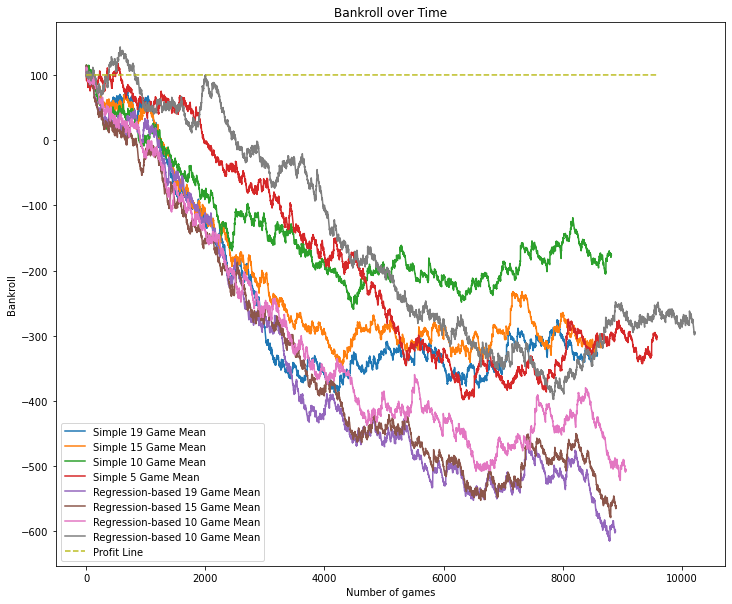

In [114]:
#plotting 19 game mean

#create x and y axis for each version of the model. 

#y axis is bankroll level for a given point in time

y = fixedstakes(x_19) #passes x_19 (our list of profits and losses for the 19 game mean) to fixed stakes to determine outcome

n=1
x = []        #creates a corresponding x axis of the same length
for i in range(1,1+len(y)):
    x.append(n)
    n = n+1

plt.plot(x,y, label = 'Simple 19 Game Mean')

y1 = fixedstakes(x_15)

n=1
x1 = []
for i in range(1,1+len(y1)):
    x1.append(n)
    n = n+1
    
plt.plot(x1,y1, label = 'Simple 15 Game Mean')

y2 = fixedstakes(x_10)
    
n=1
x2 = []
for i in range(1,1+len(y2)):
    x2.append(n)
    n = n+1
    
plt.plot(x2,y2, label = 'Simple 10 Game Mean')

y3 = fixedstakes(x_5)
    
n=1
x3 = []
for i in range(1,1+len(y3)):
    x3.append(n)
    n = n+1
    
plt.plot(x3,y3, label = 'Simple 5 Game Mean')
    
y4 = fixedstakes(x_19_reg)
    
n=1
x4 = []
for i in range(1,1+len(y4)):
    x4.append(n)
    n = n+1
    
plt.plot(x4,y4, label = 'Regression-based 19 Game Mean')

y5 = fixedstakes(x_15_reg)
    
n=1
x5 = []
for i in range(1,1+len(y5)):
    x5.append(n)
    n = n+1
    
plt.plot(x5,y5, label = 'Regression-based 15 Game Mean')


y6 = fixedstakes(x_10_reg)
    
n=1
x6 = []
for i in range(1,1+len(y6)):
    x6.append(n)
    n = n+1
    
plt.plot(x6,y6, label = 'Regression-based 10 Game Mean')

y7 = fixedstakes(x_5_reg)
    
n=1
x7 = []
for i in range(1,1+len(y7)):
    x7.append(n)
    n = n+1
    
plt.plot(x7,y7, label = 'Regression-based 10 Game Mean')
         
#adding a profit line
profit_list = []
for i in range(1,1+len(y3)):
    profit_list.append(100)
    
x8 = x3
y8 = profit_list

plt.plot(x8,y8, label = 'Profit Line', linestyle = '--')

#plt.rcParams["figure.figsize"]=20,15

plt.legend()
plt.title('Bankroll over Time')
plt.ylabel('Bankroll')
plt.xlabel('Number of games')



plt.show()

#### Higher value threshold

The cells below raise the threshold required to make a bet, adapting the forumla used previoiusly

In [115]:
#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_19'] > row['draw_value_estimate_19'] and row['home_value_estimate_19'] > row['away_value_estimate_19']and row['home_value_estimate_19'] >2:
        val = 'home'
    elif row['away_value_estimate_19'] > row['draw_value_estimate_19'] and row['away_value_estimate_19'] > row['home_value_estimate_19']and row['away_value_estimate_19'] >2:
        val = 'away'
    elif row['draw_value_estimate_19'] > row['home_value_estimate_19'] and row['draw_value_estimate_19'] > row['away_value_estimate_19']and row['draw_value_estimate_19'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_19_2'] = df.apply(f, axis=1)


#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_15'] > row['draw_value_estimate_15'] and row['home_value_estimate_15'] > row['away_value_estimate_15']and row['home_value_estimate_15'] >2:
        val = 'home'
    elif row['away_value_estimate_15'] > row['draw_value_estimate_15'] and row['away_value_estimate_15'] > row['home_value_estimate_15']and row['away_value_estimate_15'] >2:
        val = 'away'
    elif row['draw_value_estimate_15'] > row['home_value_estimate_15'] and row['draw_value_estimate_15'] > row['away_value_estimate_15']and row['draw_value_estimate_15'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_15_2'] = df.apply(f, axis=1)

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_10'] > row['draw_value_estimate_10'] and row['home_value_estimate_10'] > row['away_value_estimate_10']and row['home_value_estimate_10'] >2:
        val = 'home'
    elif row['away_value_estimate_10'] > row['draw_value_estimate_10'] and row['away_value_estimate_10'] > row['home_value_estimate_10']and row['away_value_estimate_10'] >2:
        val = 'away'
    elif row['draw_value_estimate_10'] > row['home_value_estimate_10'] and row['draw_value_estimate_10'] > row['away_value_estimate_10']and row['draw_value_estimate_10'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_10_2'] = df.apply(f, axis=1)

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_5'] > row['draw_value_estimate_5'] and row['home_value_estimate_5'] > row['away_value_estimate_5']and row['home_value_estimate_5'] >2:
        val = 'home'
    elif row['away_value_estimate_5'] > row['draw_value_estimate_5'] and row['away_value_estimate_5'] > row['home_value_estimate_5']and row['away_value_estimate_5'] >2:
        val = 'away'
    elif row['draw_value_estimate_5'] > row['home_value_estimate_5'] and row['draw_value_estimate_5'] > row['away_value_estimate_5']and row['draw_value_estimate_5'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_5_2'] = df.apply(f, axis=1)

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_19_reg'] > row['draw_value_estimate_19_reg'] and row['home_value_estimate_19_reg'] > row['away_value_estimate_19_reg']and row['home_value_estimate_19_reg'] >2:
        val = 'home'
    elif row['away_value_estimate_19_reg'] > row['draw_value_estimate_19_reg'] and row['away_value_estimate_19_reg'] > row['home_value_estimate_19_reg']and row['away_value_estimate_19_reg'] >2:
        val = 'away'
    elif row['draw_value_estimate_19_reg'] > row['home_value_estimate_19_reg'] and row['draw_value_estimate_19_reg'] > row['away_value_estimate_19_reg']and row['draw_value_estimate_19_reg'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_19_reg_2'] = df.apply(f, axis=1)


#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_15_reg'] > row['draw_value_estimate_15_reg'] and row['home_value_estimate_15_reg'] > row['away_value_estimate_15_reg']and row['home_value_estimate_15_reg'] >2:
        val = 'home'
    elif row['away_value_estimate_15_reg'] > row['draw_value_estimate_15_reg'] and row['away_value_estimate_15_reg'] > row['home_value_estimate_15_reg']and row['away_value_estimate_15_reg'] >2:
        val = 'away'
    elif row['draw_value_estimate_15_reg'] > row['home_value_estimate_15_reg'] and row['draw_value_estimate_15_reg'] > row['away_value_estimate_15_reg']and row['draw_value_estimate_15_reg'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_15_reg_2'] = df.apply(f, axis=1)

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_10_reg'] > row['draw_value_estimate_10_reg'] and row['home_value_estimate_10_reg'] > row['away_value_estimate_10_reg']and row['home_value_estimate_10_reg'] >2:
        val = 'home'
    elif row['away_value_estimate_10_reg'] > row['draw_value_estimate_10_reg'] and row['away_value_estimate_10_reg'] > row['home_value_estimate_10_reg']and row['away_value_estimate_10_reg'] >2:
        val = 'away'
    elif row['draw_value_estimate_10_reg'] > row['home_value_estimate_10_reg'] and row['draw_value_estimate_10_reg'] > row['away_value_estimate_10_reg']and row['draw_value_estimate_10_reg'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_10_reg_2'] = df.apply(f, axis=1)

#function compares the value and selects the most 'profitable' bet
def f(row):
    if row['home_value_estimate_5_reg'] > row['draw_value_estimate_5_reg'] and row['home_value_estimate_5_reg'] > row['away_value_estimate_5_reg']and row['home_value_estimate_5_reg'] >2:
        val = 'home'
    elif row['away_value_estimate_5_reg'] > row['draw_value_estimate_5_reg'] and row['away_value_estimate_5_reg'] > row['home_value_estimate_5_reg']and row['away_value_estimate_5_reg'] >2:
        val = 'away'
    elif row['draw_value_estimate_5_reg'] > row['home_value_estimate_5_reg'] and row['draw_value_estimate_5_reg'] > row['away_value_estimate_5_reg']and row['draw_value_estimate_5_reg'] >2:
        val = 'draw' 
    else:
        val = 'nobet'
        
    return val

#create new column 'bet' using the function above
df['bet_5_reg_2'] = df.apply(f, axis=1)

Cell below re-calculates the recommended bets, outcomes and expected values

In [116]:
#compares the 'value' bets of the model and what actually happened

def g_19_2(row):
    if row['bet_19_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_19_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_19_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_15_2(row):
    if row['bet_15_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_15_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_15_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_10_2(row):
    if row['bet_10_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_10_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_10_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val


def g_5_2(row):
    if row['bet_5_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_5_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_5_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

        


def g_19_reg_2(row):
    if row['bet_19_reg_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_19_reg_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_19_reg_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_15_reg_2(row):
    if row['bet_15_reg_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_15_reg_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_15_reg_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val

def g_10_reg_2(row):
    if row['bet_10_reg_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_10_reg_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_10_reg_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val


def g_5_reg_2(row):
    if row['bet_5_reg_2'] == 'home':
        if row['result']=='homewin':
            val = (row['home_odds'] -1)
        else:
            val = -1
    elif row['bet_5_reg_2'] == 'away':
        if row['result']=='awaywin':
            val = (row['away_odds']-1)
        else:
            val = -1
    elif row['bet_5_reg_2'] == 'draw':
        if row['result']=='draw':
            val = (row['draw_odds']-1)
        else:
            val = -1 
    else:
        val = 0
        
    return val


#create new column 'profit' using the function above
df['profit/loss_19_2'] = df.apply(g_19_2, axis=1)
#create a list of the profit/loss scores
x_19_2 = df['profit/loss_19_2'].to_list()
for i in x_19_2:
    if i == 0:
        x_19_2.remove(i)

#create new column 'profit' using the function above
df['profit/loss_15_2'] = df.apply(g_15_2, axis=1)
#create a list of the profit/loss scores
x_15_2 = df['profit/loss_15_2'].to_list()
for i in x_15_2:
    if i == 0:
        x_15_2.remove(i)

#create new column 'profit' using the function above
df['profit/loss_10_2'] = df.apply(g_10_2, axis=1)
#create a list of the profit/loss scores
x_10_2 = df['profit/loss_10_2'].to_list()
for i in x_10_2:
    if i == 0:
        x_10_2.remove(i)
        
#create new column 'profit' using the function above
df['profit/loss_5_2'] = df.apply(g_5_2, axis=1)
#create a list of the profit/loss scores
x_5_2 = df['profit/loss_5_2'].to_list()
for i in x_5_2:
    if i == 0:
        x_5_2.remove(i)
        
#create new column 'profit' using the function above
df['profit/loss_19_reg_2'] = df.apply(g_19_reg_2, axis=1)
#create a list of the profit/loss scores
x_19_reg_2 = df['profit/loss_19_reg_2'].to_list()
for i in x_19_reg_2:
    if i == 0:
        x_19_reg_2.remove(i)

#create new column 'profit' using the function above
df['profit/loss_15_reg_2'] = df.apply(g_15_reg_2, axis=1)
#create a list of the profit/loss scores
x_15_reg_2 = df['profit/loss_15_reg_2'].to_list()
for i in x_15_reg_2:
    if i == 0:
        x_15_reg_2.remove(i)

#create new column 'profit' using the function above
df['profit/loss_10_reg_2'] = df.apply(g_10_reg_2, axis=1)
#create a list of the profit/loss scores
x_10_reg_2 = df['profit/loss_10_reg_2'].to_list()
for i in x_10_reg_2:
    if i == 0:
        x_10_reg_2.remove(i)
        
#create new column 'profit' using the function above
df['profit/loss_5_reg_2'] = df.apply(g_5_reg_2, axis=1)
#create a list of the profit/loss scores
x_5_reg_2 = df['profit/loss_5_reg_2'].to_list()
for i in x_5_reg_2:
    if i == 0:
        x_5_reg_2.remove(i)
        

        
#create an 'expected return' based on the average return to a bet
expected_return_19_reg_2 = sum(x_19_reg_2)/len(x_19_reg_2)
expected_return_19_reg_2 = round((100*(1 + expected_return_19_reg_2)),2)

expected_return_15_reg_2 = sum(x_15_reg_2)/len(x_15_reg_2)
expected_return_15_reg_2 = round((100*(1 + expected_return_15_reg_2)),2)

expected_return_10_reg_2 = sum(x_10_reg_2)/len(x_10_reg_2)
expected_return_10_reg_2 = round((100*(1 + expected_return_10_reg_2)),2)

expected_return_5_reg_2 = sum(x_5_reg_2)/len(x_5_reg_2)
expected_return_5_reg_2 = round((100*(1 + expected_return_5_reg_2)),2)

#create an 'expected return' based on the average return to a bet
expected_return_19_2 = sum(x_19_2)/len(x_19_2)
expected_return_19_2 = round((100*(1 + expected_return_19_2)),2)

expected_return_15_2 = sum(x_15_2)/len(x_15_2)
expected_return_15_2 = round((100*(1 + expected_return_15_2)),2)

expected_return_10_2 = sum(x_10_2)/len(x_10_2)
expected_return_10_2 = round((100*(1 + expected_return_10_2)),2)

expected_return_5_2 = sum(x_5_2)/len(x_5_2)
expected_return_5_2 = round((100*(1 + expected_return_5_2)),2)

In [117]:
print('Expected return using simple 19 game mean (adjusted): '+ str(expected_return_19_2))
print('Expected return using regression-based 19 game mean (adjusted): '+ str(expected_return_19_reg_2))
print('Expected return using simple 15 game mean (adjusted): '+ str(expected_return_15_2))
print('Expected return using regression-based 15 game mean (adjusted): '+ str(expected_return_15_reg_2))
print('Expected return using simple 10 game mean (adjusted): '+ str(expected_return_10_2))
print('Expected return using regression-based 10 game mean (adjusted): '+ str(expected_return_10_reg_2))
print('Expected return using simple 5 game mean (adjusted): '+ str(expected_return_5_2))
print('Expected return using regression-based 5 game mean (adjusted): '+ str(expected_return_5_reg_2))



Expected return using simple 19 game mean (adjusted): 100.13
Expected return using regression-based 19 game mean (adjusted): 99.28
Expected return using simple 15 game mean (adjusted): 99.94
Expected return using regression-based 15 game mean (adjusted): 98.34
Expected return using simple 10 game mean (adjusted): 100.98
Expected return using regression-based 10 game mean (adjusted): 97.49
Expected return using simple 5 game mean (adjusted): 99.77
Expected return using regression-based 5 game mean (adjusted): 100.55


This cell calculates the adjusted value counts

In [118]:
print('Simple 19 Game Model (Adjusted) Value Counts:')
print(df['bet_19_2'].value_counts())
print('')
print('Regression-based 19 Game Model (Adjusted) Value Counts:')
print(df['bet_19_reg_2'].value_counts())
print('')
print('Simple 15 Game Model (Adjusted) Value Counts:')
print(df['bet_15_2'].value_counts())
print('')
print('Regression-based 15 Game Model (Adjusted) Value Counts:')
print(df['bet_15_reg_2'].value_counts())
print('')
print('Simple 10 Game Model (Adjusted) Value Counts:')
print(df['bet_10_2'].value_counts())
print('')
print('Regression-based 10 Game Model (Adjusted) Value Counts:')
print(df['bet_10_reg_2'].value_counts())
print('')
print('Simple 5 Game Model (Adjusted) Value Counts:')
print(df['bet_5_2'].value_counts())
print('Regression-based 5 Game Model (Adjusted) Value Counts:')
print(df['bet_5_reg_2'].value_counts())
print('')

Simple 19 Game Model (Adjusted) Value Counts:
nobet    12013
home       147
away       115
draw        15
Name: bet_19_2, dtype: int64

Regression-based 19 Game Model (Adjusted) Value Counts:
nobet    11448
home       453
away       373
draw        16
Name: bet_19_reg_2, dtype: int64

Simple 15 Game Model (Adjusted) Value Counts:
nobet    11972
home       166
away       134
draw        18
Name: bet_15_2, dtype: int64

Regression-based 15 Game Model (Adjusted) Value Counts:
nobet    11358
home       493
away       423
draw        16
Name: bet_15_reg_2, dtype: int64

Simple 10 Game Model (Adjusted) Value Counts:
nobet    11856
away       217
home       199
draw        18
Name: bet_10_2, dtype: int64

Regression-based 10 Game Model (Adjusted) Value Counts:
nobet    11134
home       614
away       533
draw         9
Name: bet_10_reg_2, dtype: int64

Simple 5 Game Model (Adjusted) Value Counts:
nobet    11445
away       471
home       325
draw        49
Name: bet_5_2, dtype: int64
Regressio

This cell plots the revised version of the model on a graph, as before

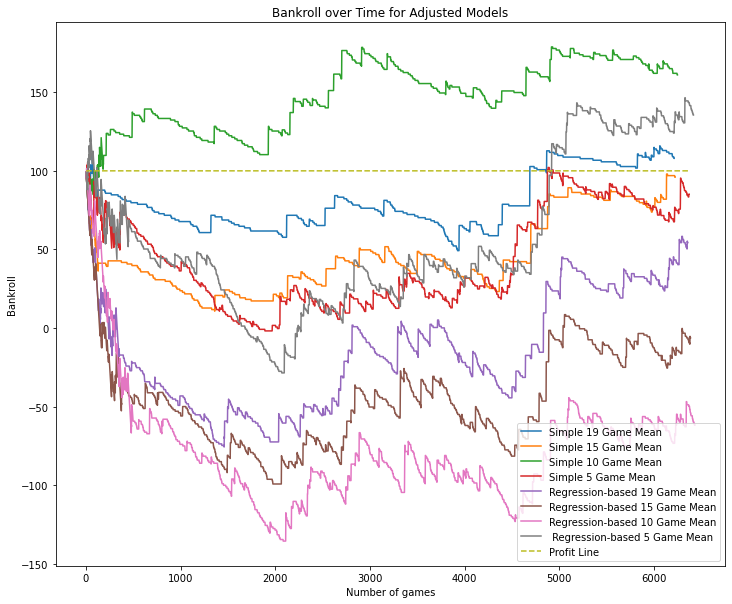

In [119]:
#plotting 19 game mean
y = fixedstakes(x_19_2)

n=1
x = []
for i in range(1,1+len(y)):
    x.append(n)
    n = n+1

plt.plot(x,y, label = 'Simple 19 Game Mean')

y1 = fixedstakes(x_15_2)

n=1
x1 = []
for i in range(1,1+len(y1)):
    x1.append(n)
    n = n+1
    
plt.plot(x1,y1, label = 'Simple 15 Game Mean')

y2 = fixedstakes(x_10_2)
    
n=1
x2 = []
for i in range(1,1+len(y2)):
    x2.append(n)
    n = n+1
    
plt.plot(x2,y2, label = 'Simple 10 Game Mean')

y3 = fixedstakes(x_5_2)
    
n=1
x3 = []
for i in range(1,1+len(y3)):
    x3.append(n)
    n = n+1

plt.plot(x3,y3, label = 'Simple 5 Game Mean')

##############################################################################

#plotting 19 game mean
y4 = fixedstakes(x_19_reg_2)

n=1
x4 = []
for i in range(1,1+len(y4)):
    x4.append(n)
    n = n+1

plt.plot(x4,y4, label = 'Regression-based 19 Game Mean')

y5 = fixedstakes(x_15_reg_2)

n=1
x5 = []
for i in range(1,1+len(y5)):
    x5.append(n)
    n = n+1
    
plt.plot(x5,y5, label = 'Regression-based 15 Game Mean')

y6 = fixedstakes(x_10_reg_2)
    
n=1
x6 = []
for i in range(1,1+len(y6)):
    x6.append(n)
    n = n+1
    
plt.plot(x6,y6, label = 'Regression-based 10 Game Mean')

y7 = fixedstakes(x_5_reg_2)
    
n=1
x7 = []
for i in range(1,1+len(y7)):
    x7.append(n)
    n = n+1

plt.plot(x7,y7, label = ' Regression-based 5 Game Mean')

#adding a profit line
profit_list = []
for i in range(1,1+len(y3)):
    profit_list.append(100)
    
x8 = x3
y8 = profit_list

plt.plot(x8,y8, label = 'Profit Line', linestyle = '--')

plt.rcParams["figure.figsize"]=20,15

plt.legend()
plt.title('Bankroll over Time for Adjusted Models')
plt.ylabel('Bankroll')
plt.xlabel('Number of games')



plt.show()

# PART 6: Examining the Results

## - Split the data up to focus on the metric which returned a profit
## - Examine value counts to help understand how it made a profit
## - Calculate average odds and value counts


In [120]:
#create a new df to examine the predictions further
profit_df = df.loc[(df['profit/loss_10_2'] != 0),['year','league','result','home_team','away_team','home_odds','home_odds_pred_10','draw_odds','draw_odds_pred_10','away_odds','away_odds_pred_10','bet_10','result','profit/loss_10_2']]


The cell below creates two new columns: 'Predicted Winner' - the team the model recommended betting on to win, and the 'Predicted Loser' - the team the model recommended betting on to lose. The value counts are printed to try and spot patterns. 

In [121]:
profit_df = profit_df.loc[(df['profit/loss_10_2'] != -1.0)]

def predicted_winner(row):
    if row['bet_10'] == 'home':
        val = row['home_team']
    elif row['bet_10'] == 'away':
        val = row['away_team']
    else: val = 'draw'
    return val

profit_df['predicted_winner'] = profit_df.apply(predicted_winner, axis=1)

def predicted_loser(row):
    if row['bet_10'] == 'home':
        val = row['away_team']
    elif row['bet_10'] == 'away':
        val = row['home_team']
    else: val = 'draw'
    return val

profit_df['predicted_loser'] = profit_df.apply(predicted_loser, axis=1)
    
profit_df['predicted_loser'].value_counts()

Chelsea                 5
Real Madrid             5
Barcelona               5
Paris Saint Germain     3
Manchester United       3
Napoli                  2
Atletico Madrid         2
Arsenal                 2
Tottenham               2
Manchester City         2
Bayer Leverkusen        2
Wolfsburg               2
Monaco                  2
Inter                   2
Juventus                1
draw                    1
Hoffenheim              1
Leicester               1
Liverpool               1
Kuban Krasnodar         1
Empoli                  1
Roma                    1
AC Milan                1
Udinese                 1
FC Rostov               1
CSKA Moscow             1
Zenit St. Petersburg    1
Fiorentina              1
Bournemouth             1
Everton                 1
Dinamo Moscow           1
Marseille               1
Fortuna Duesseldorf     1
Crystal Palace          1
Getafe                  1
Name: predicted_loser, dtype: int64

This cell shows the mean value of the succesful bets. This can be used to understand the sort of predictions the model makes. 

In [122]:
profit_df['profit/loss_10_2'].mean()

7.250166666666666

This cell prints the value counts, to spot patterns in the predicitons. 

In [123]:
profit_df['bet_10'].value_counts()

home    35
away    24
draw     1
Name: bet_10, dtype: int64